In [1]:
import numpy as np
import pandas as pd
import io
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error,r2_score

In [2]:
from sklearn import metrics
from sklearn.model_selection import KFold
import xgboost as xgb
import math

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')
# #click the link showed below and log in to your account, copy paste the link showed in that website to the text box below and tap 'enter'

In [4]:
hos = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/STATS_402/VDH-COVID-19-PublicUseDataset-KeyMeasures-Hospitals (3).csv')

In [5]:
hos['Date'] = pd.to_datetime(hos['Date'],format='%m/%d/%Y')

In [6]:
hos.sort_values('Date',inplace=True)

In [7]:
recover = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/STATS_402/Virginia recover data.csv')

In [8]:
recover['date'] = pd.to_datetime(recover['date'],format='%Y/%m/%d')

In [9]:
re = recover[['date','Recovered']]

In [10]:
re.dropna(inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [11]:
re_df = pd.merge(re,hos,left_on='date',right_on='Date')

In [12]:
re_df.drop(columns=['PPE','Capacity','Surge Capacity','Beds Occupied','Date','date'],inplace=True)

In [13]:
re_df['index'] = np.arange(np.shape(re_df)[0])

In [14]:
re_df['new_recovered'] = re_df['Recovered'] - re_df['Recovered'].shift(1) # create the feature new recovered
re_df['new_recovered'] = re_df['new_recovered'].apply(lambda x:0 if x<0 else x)

In [15]:
re_X = re_df.drop(columns=['Recovered'])
re_y = re_df[['Recovered','new_recovered']]

In [16]:
# the function to calculate the mean absolute percentage error
def MAPE(test,pre):
  return sum(abs((test-pre)/test))/len(pre)

In [17]:
re.iloc[60]

date         2020-06-13 00:00:00
Recovered                   7131
Name: 62, dtype: object

In [18]:
re.iloc[-1]

date         2021-02-22 00:00:00
Recovered                  45892
Name: 316, dtype: object

In [19]:
re_df[60:315]

Recovered  Total COVID-19 Patients  ...  index  new_recovered
60      7131.0                      959  ...     60          129.0
61      7178.0                      958  ...     61           47.0
62      7230.0                      902  ...     62           52.0
63      7341.0                      904  ...     63          111.0
64      7429.0                      938  ...     64           88.0
..         ...                      ...  ...    ...            ...
310    44595.0                     1828  ...    310            0.0
311    45524.0                     1671  ...    311          929.0
312    45667.0                     1594  ...    312          143.0
313    45746.0                     1548  ...    313           79.0
314    45892.0                     1540  ...    314          146.0

[255 rows x 6 columns]

## Accumulated Recovered

In [20]:
re_X_train,re_X_test,re_y_train,re_y_test = train_test_split(re_X[:-60],re_y[re_y.columns[0]][60:],test_size=0.3,random_state=1024,shuffle=True)

In [21]:
re_train_x = re_X_train.copy()
re_target = pd.DataFrame(re_y_train.copy())
re_test_x = re_X_test.copy()

re_features = re_train_x.columns
re_feature_importance_df = pd.DataFrame() # create feature importance dataframe

In [22]:
#xgb model
xlf=xgb.XGBRegressor(max_depth=8,
                     learning_rate=0.05,
                     n_estimators=1000,
                     )
answers = []
model = []
score = 0
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True,random_state=4096)
for fold_n, (train_index, valid_index) in enumerate(folds.split(re_train_x)):
    X_train, X_valid = re_train_x.iloc[train_index], re_train_x.iloc[valid_index]
    y_train, y_valid = re_target.iloc[train_index], re_target.iloc[valid_index]
    
    xlf.fit(re_X_train,re_y_train,eval_set=[(X_valid, y_valid)],verbose=100,
    early_stopping_rounds=100)
    model.append(xlf)
    y_pre=xlf.predict(X_valid)
    #print('每一折验证分数:'+str(mean_squared_error(y_valid,y_pre)))
    print('每一折验证分数:'+str(mean_absolute_percentage_error(y_valid,y_pre)))
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = re_features
    fold_importance_df["importance"] = xlf.feature_importances_
    fold_importance_df["fold"] = fold_n + 1
    re_feature_importance_df = pd.concat([re_feature_importance_df, fold_importance_df], axis=0)
    
    score = score + mean_absolute_percentage_error(y_valid,y_pre)
    y_pred_valid = xlf.predict(re_test_x)
    answers.append(y_pred_valid)
xgb_pre=sum(answers)/n_fold
print('xgb验证分数'+str(math.sqrt(score/n_fold)))

[18:00:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:21578.4
Will train until validation_0-rmse hasn't improved in 100 rounds.
[100]	validation_0-rmse:152.097
[200]	validation_0-rmse:4.76467
[300]	validation_0-rmse:0.935853
[400]	validation_0-rmse:0.226123
[500]	validation_0-rmse:0.067964
[600]	validation_0-rmse:0.057146
Stopping. Best iteration:
[528]	validation_0-rmse:0.057145

每一折验证分数:2.393737216589072e-06
[18:00:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:24206.4
Will train until validation_0-rmse hasn't improved in 100 rounds.
[100]	validation_0-rmse:263.676
[200]	validation_0-rmse:15.7288
[300]	validation_0-rmse:1.4995
[400]	validation_0-rmse:0.250481
[500]	validation_0-rmse:0.0889
[600]	validation_0-rmse:0.080463
Stopping. Best iteration:
[528]	validation_0-rmse:0.080463

每一折验证分数:3.234189

In [23]:
re_ans = pd.DataFrame(re_y_test)
re_ans['y_test'] = re_ans['Recovered']
re_ans['xgb_pre'] = xgb_pre
re_ans.sort_index(inplace=True)

In [24]:
#evaluation metrics
mean_absolute_percentage_error(re_y_test,xgb_pre),r2_score(re_y_test,xgb_pre),mean_squared_error(re_y_test,xgb_pre),mean_squared_error(re_y_test,xgb_pre)/np.average(re_y_test),mean_squared_error(re_y_test,xgb_pre,squared=False)/np.average(re_y_test)

(0.010189492683265945,
 0.9992809482236684,
 74202.9988291759,
 3.4742505828875987,
 0.012754117405371222)

In [25]:
MAPE(re_y_test,xgb_pre)

0.010189492683265947

In [26]:
accumulated_recovered_model=model # store the model

In [27]:
re_f = re_feature_importance_df.sort_values(by=['importance'],ascending=False)
re_f.to_csv('recovered_feature_importance.csv',index=True)

In [28]:
MAPE(re_ans['y_test'],re_ans['xgb_pre'])

0.010189492683265945

<function matplotlib.pyplot.close>

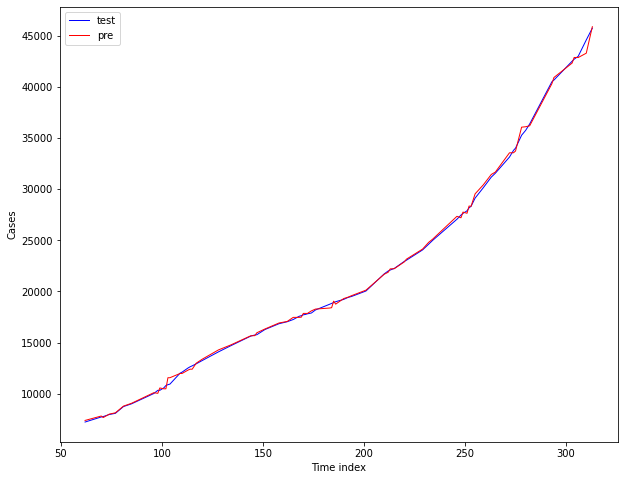

In [29]:
plt.figure(figsize=(10,8))
#plt.scatter(re_X_test['index'],re_y_test.values,label='test',facecolors='none',edgecolors='blue',linewidth=1)
#plt.scatter(re_X_test['index'],xgb_pre,label='pre',facecolors='none',edgecolors='red',linewidth=1)

plt.plot(re_ans.index,re_ans['y_test'],label='test',c='blue',linewidth=1)
plt.plot(re_ans.index,re_ans['xgb_pre'],label='pre',c='red',linewidth=1)


plt.xlabel('Time index')
plt.ylabel('Cases')

plt.legend()

plt.close

## New Recover

In [104]:
nre_X_train,nre_X_test,nre_y_train,nre_y_test = train_test_split(re_X[:-7],re_y[re_y.columns[1]][7:],test_size=0.3,random_state=1024,shuffle=True)

In [105]:
nre_train_x = nre_X_train.copy()
nre_target = pd.DataFrame(nre_y_train.copy())
nre_test_x = nre_X_test.copy()

nre_features = nre_train_x.columns
nre_feature_importance_df = pd.DataFrame()

In [106]:
#xgb
xlf=xgb.XGBRegressor(max_depth=8,
                     learning_rate=0.05,
                     n_estimators=1000,
                     )
answers = []
model = []
score = 0
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True,random_state=4096)
for fold_n, (train_index, valid_index) in enumerate(folds.split(nre_train_x)):
    X_train, X_valid = nre_train_x.iloc[train_index], nre_train_x.iloc[valid_index]
    y_train, y_valid = nre_target.iloc[train_index], nre_target.iloc[valid_index]
    
    xlf.fit(nre_X_train,nre_y_train,eval_set=[(X_valid, y_valid)],verbose=100,
    early_stopping_rounds=100)
    model.append(xlf)
    y_pre=xlf.predict(X_valid)
    #print('每一折验证分数:'+str(mean_squared_error(y_valid,y_pre)))
    print('每一折验证分数:'+str(mean_absolute_percentage_error(y_valid,y_pre)))
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = nre_features
    fold_importance_df["importance"] = xlf.feature_importances_
    fold_importance_df["fold"] = fold_n + 1
    nre_feature_importance_df = pd.concat([nre_feature_importance_df, fold_importance_df], axis=0)
    
    score = score + mean_absolute_percentage_error(y_valid,y_pre)
    y_pred_valid = xlf.predict(nre_test_x)
    answers.append(y_pred_valid)
xgb_pre=sum(answers)/n_fold
print('xgb验证分数'+str(math.sqrt(score/n_fold)))

[13:12:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:223.077
Will train until validation_0-rmse hasn't improved in 100 rounds.
[100]	validation_0-rmse:18.437
[200]	validation_0-rmse:3.29269
[300]	validation_0-rmse:1.00708
[400]	validation_0-rmse:0.362701
[500]	validation_0-rmse:0.095309
[600]	validation_0-rmse:0.029615
[700]	validation_0-rmse:0.009974
[800]	validation_0-rmse:0.003478
[900]	validation_0-rmse:0.001654
Stopping. Best iteration:
[884]	validation_0-rmse:0.001654

每一折验证分数:1.3107044243330489e-05
[13:12:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:191.021
Will train until validation_0-rmse hasn't improved in 100 rounds.
[100]	validation_0-rmse:13.7697
[200]	validation_0-rmse:2.79358
[300]	validation_0-rmse:0.972112
[400]	validation_0-rmse:0.384407
[500]	validation_0-rmse:0.102052
[600]	v

In [110]:
nre_ans = pd.DataFrame(nre_y_test)
nre_ans['y_test'] = nre_ans['new_recovered']
nre_ans['xgb_pre'] = xgb_pre
nre_ans.sort_index(inplace=True)

In [115]:
MAPE(nre_ans[nre_ans['y_test']!=0]['y_test'],nre_ans[nre_ans['y_test']!=0]['xgb_pre'])

0.7428384508887835

In [107]:
#evaluation
mean_absolute_percentage_error(nre_y_test,xgb_pre),r2_score(nre_y_test,xgb_pre),mean_squared_error(nre_y_test,xgb_pre),mean_squared_error(nre_y_test,xgb_pre)/np.average(nre_y_test),mean_squared_error(nre_y_test,xgb_pre,squared=False)/np.average(nre_y_test)

(2.196718419080657e+16,
 -0.04881580734247226,
 253.54538982282466,
 1.2392489661481154)

In [108]:
nre_y_test[nre_y_test==0]

99     0.0
53     0.0
238    0.0
Name: new_recovered, dtype: float64

In [109]:
MAPE(nre_y_test,xgb_pre)

inf

In [45]:
new_recover_model = model # store the model

In [76]:
nre_f = nre_feature_importance_df.sort_values(by=['importance'],ascending=False)
nre_f.to_csv('new_recovered_feature_importance.csv',index=True)

<function matplotlib.pyplot.close>

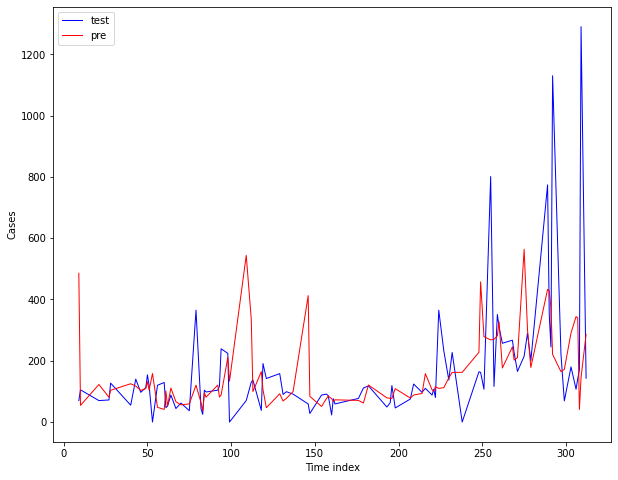

In [78]:
plt.figure(figsize=(10,8))
#plt.scatter(re_X_test['index'],re_y_test.values,label='test',facecolors='none',edgecolors='blue',linewidth=1)
#plt.scatter(re_X_test['index'],xgb_pre,label='pre',facecolors='none',edgecolors='red',linewidth=1)

plt.plot(nre_ans.index,nre_ans['y_test'],label='test',c='blue',linewidth=1)
plt.plot(nre_ans.index,nre_ans['xgb_pre'],label='pre',c='red',linewidth=1)


plt.xlabel('Time index')
plt.ylabel('Cases')

plt.legend()

plt.close

## Model 1



In [30]:
cases = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/STATS_402/VA situation(1).csv')

In [31]:
cases['date'] = pd.to_datetime(cases['submission_date'],format='%m/%d/%Y')

In [32]:
#create new features
cases['quarter'] = cases['date'].dt.quarter 
cases['month'] = cases['date'].dt.month

In [33]:
cases['index'] = np.arange(np.shape(cases)[0]) #change date_time to index

In [34]:
intervention = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/STATS_402/Virginia state intervention(1).csv')
intervention = intervention.dropna(how='all').dropna(axis=1,how='all')

In [35]:
#drop useless features
columns = intervention.columns
lst = []
for index,name in enumerate(columns):
  if name.find('Flag')==-1 and name.find('Notes')==-1:
    lst.append(index)

In [36]:
intervention = intervention[intervention.columns[lst]]

In [37]:
intervention = intervention[intervention.columns[5:]]

In [38]:
intervention['Date'] = intervention['Date'].apply(lambda x:int(x))

In [39]:
intervention['date'] = pd.to_datetime(intervention['Date'],format='%Y%m%d')

In [40]:
#create new features
intervention['weekday'] = intervention['date'].dt.weekday
intervention['quarter'] = intervention['date'].dt.quarter
intervention['month'] = intervention['date'].dt.month
intervention['day'] = intervention['date'].dt.day
# intervention['index'] = np.arange(np.shape(intervention)[0])

In [41]:
df = pd.merge(cases,intervention,on='date')
df = df[df.columns[2:]]
df['time'] = np.arange(np.shape(df)[0])

In [42]:
#create new features
df['death_1'] = df['tot_death'].shift(1).bfill()
df['new_death_1'] = df['new_death'].shift(1).bfill()

df['cases_1'] = df['tot_cases'].shift(1).bfill()
df['cases_3'] = df['tot_cases'].shift(3).bfill()
df['cases_7'] = df['tot_cases'].shift(7).bfill()
df['cases_14'] = df['tot_cases'].shift(14).bfill()

In [43]:
df[143:398]

tot_cases  conf_cases  prob_cases  ...   cases_3   cases_7  cases_14
143      54506     52103.0      2403.0  ...   52647.0   50681.0   44607.0
144      54886     52460.0      2426.0  ...   53211.0   51251.0   45398.0
145      55331     52917.0      2414.0  ...   53869.0   51738.0   46239.0
146      55775     53318.0      2457.0  ...   54506.0   52177.0   46905.0
147      56238     53769.0      2469.0  ...   54886.0   52647.0   47856.0
..         ...         ...         ...  ...       ...       ...       ...
393     559930    442757.0    117173.0  ...  553308.0  544209.0  521467.0
394     561812    444150.0    117662.0  ...  555592.0  547424.0  526177.0
395     564115    445808.0    118307.0  ...  557896.0  549999.0  529125.0
396     565270    446642.0    118628.0  ...  559930.0  551538.0  530825.0
397     567039    447840.0    119199.0  ...  561812.0  553308.0  534116.0

[255 rows x 61 columns]

In [44]:
#new_df = pd.merge(df,re,on='date')

In [45]:
columns_to_be_dropped = ['tot_cases', 'conf_cases', 'prob_cases', 'pnew_case', 'conf_death', 'prob_death', 'pnew_death',
                         'created_at', 'consent_cases', 'consent_deaths','Date','C5_Close public transport','E3_Fiscal measures','E4_International support',
                         'H4_Emergency investment in healthcare', 'H5_Investment in vaccines','ConfirmedCases', 'ConfirmedDeaths','date']

In [46]:
y_columns = ['tot_cases','new_case','tot_death','new_death']

In [47]:
X = df.drop(columns=columns_to_be_dropped)
#X = new_df.drop(columns=columns_to_be_dropped)

In [48]:
y = df[y_columns]

In [49]:
#y['new_recovered'] = y['Recovered'] - y['Recovered'].shift(1)

In [50]:
X_train,X_test,y_train,y_test = train_test_split(X[:-60],y[y.columns[0]][60:],test_size=0.3,random_state=1024,shuffle=True)

In [51]:
train_x = X_train.copy()
target = pd.DataFrame(y_train.copy())
test_x = X_test.copy()

features = train_x.columns
feature_importance_df = pd.DataFrame()

In [52]:
#xgb
xlf=xgb.XGBRegressor(max_depth=8,
                     learning_rate=0.05,
                     n_estimators=1000,
                     )
answers = []
model = []
score = 0
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True,random_state=4096)
for fold_n, (train_index, valid_index) in enumerate(folds.split(train_x)):
    X_train, X_valid = train_x.iloc[train_index], train_x.iloc[valid_index]
    y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]
    
    xlf.fit(X_train,y_train,eval_set=[(X_valid, y_valid)],verbose=100,
    early_stopping_rounds=100)
    model.append(xlf)
    y_pre=xlf.predict(X_valid)
    print('每一折验证分数:'+str(mean_absolute_percentage_error(y_valid,y_pre)))
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = xlf.feature_importances_
    fold_importance_df["fold"] = fold_n + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    score = score + mean_absolute_percentage_error(y_valid,y_pre)
    y_pred_valid = xlf.predict(test_x)
    answers.append(y_pred_valid)
xgb_pre=sum(answers)/n_fold
print('xgb验证分数'+str(math.sqrt(score/n_fold)))
print(score/n_fold)

[18:00:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:400052
Will train until validation_0-rmse hasn't improved in 100 rounds.
[100]	validation_0-rmse:4951.12
[200]	validation_0-rmse:3076.55
[300]	validation_0-rmse:3068.03
Stopping. Best iteration:
[272]	validation_0-rmse:3067.51

每一折验证分数:0.02006191099371406
[18:00:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:442225
Will train until validation_0-rmse hasn't improved in 100 rounds.
[100]	validation_0-rmse:5132.7
[200]	validation_0-rmse:2713.81
[300]	validation_0-rmse:2625.29
[400]	validation_0-rmse:2620.22
[500]	validation_0-rmse:2619.76
[600]	validation_0-rmse:2619.8
Stopping. Best iteration:
[514]	validation_0-rmse:2619.7

每一折验证分数:0.031050375078977843
[18:00:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated

In [53]:
ans = pd.DataFrame(y_test)
ans['y_test'] = ans['tot_cases']
ans['xgb_pre'] = xgb_pre
ans.sort_index(inplace=True)

In [54]:
MAPE(ans[ans['y_test']!=0]['y_test'],ans[ans['y_test']!=0]['xgb_pre'])

0.017885284319214132

In [55]:
mean_absolute_percentage_error(y_test,xgb_pre),r2_score(y_test,xgb_pre),mean_squared_error(y_test,xgb_pre),mean_squared_error(y_test,xgb_pre)/np.average(y_test),mean_squared_error(y_test,xgb_pre,squared=False)/np.average(y_test)

(0.01788528431921412,
 0.9998740045445,
 8866957.93658874,
 23.965799933610306,
 0.008048308322022904)

In [56]:
y_test[y_test==0]

Series([], Name: tot_cases, dtype: int64)

In [57]:
MAPE(y_test,xgb_pre)

0.017885284319214136

In [58]:
total_model = model

In [59]:
f = feature_importance_df.sort_values(by=['importance'],ascending=False)
f.to_csv('tot_cases_feature_importance.csv',index=True)

<function matplotlib.pyplot.close>

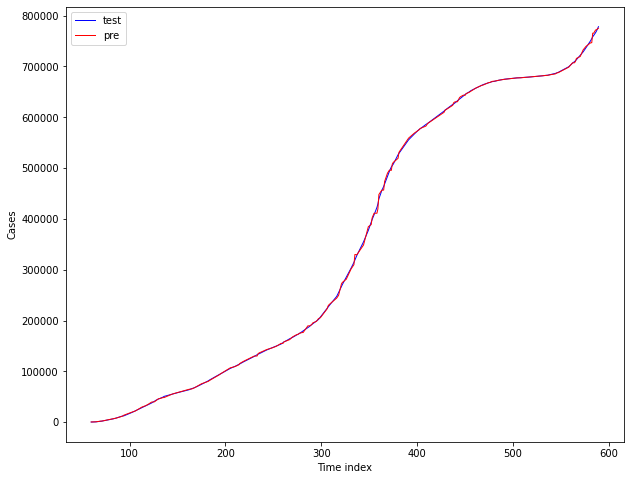

In [61]:
plt.figure(figsize=(10,8))
#plt.scatter(X_test['index'],y_test.values,label='test',facecolors='none',edgecolors='blue',linewidth=1)
#plt.scatter(X_test['index'],xgb_pre,label='pre',facecolors='none',edgecolors='red',linewidth=1)
#plt.plot(X_test['time'],y_test.values,label='test',c='blue',linewidth=1)
#plt.plot(X_test['time'],xgb_pre,label='pre',c='red',linewidth=1)

plt.plot(ans.index,ans['y_test'],label='test',c='blue',linewidth=1)
plt.plot(ans.index,ans['xgb_pre'],label='pre',c='red',linewidth=1)


plt.xlabel('Time index')
plt.ylabel('Cases')

plt.legend()

plt.close

In [62]:
# plt.figure(figsize=(10,8))
# plt.scatter(X_test['time'],y_test.values,label='test',facecolors='none',edgecolors='blue',marker='^',linewidth=1)
# plt.scatter(X_test['time'],xgb_pre,label='pre',facecolors='none',edgecolors='orange',linewidth=1)
# plt.xlabel('Time index')
# plt.ylabel('Cases')

# plt.legend()

# plt.close

## New Cases

In [152]:
X_train,X_test,y_train,y_test = train_test_split(X[:-7],y[y.columns[1]][7:],test_size=0.3,random_state=1024,shuffle=True)

In [153]:
train_x = X_train.copy()
target = pd.DataFrame(y_train.copy())
test_x = X_test.copy()

features = train_x.columns
feature_importance_df = pd.DataFrame()

In [154]:
#xgb
xlf=xgb.XGBRegressor(max_depth=8,
                     learning_rate=0.05,
                     n_estimators=1000,
                     )
answers = []
model = []
score = 0
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True,random_state=4096)
for fold_n, (train_index, valid_index) in enumerate(folds.split(train_x)):
    X_train, X_valid = train_x.iloc[train_index], train_x.iloc[valid_index]
    y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]
    
    xlf.fit(X_train,y_train,eval_set=[(X_valid, y_valid)],verbose=100,
    early_stopping_rounds=100)
    model.append(xlf)
    y_pre=xlf.predict(X_valid)
    #print('每一折验证分数:'+str(mean_squared_error(y_valid,y_pre)))
    print('每一折验证分数:'+str(mean_absolute_percentage_error(y_valid,y_pre)))
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = xlf.feature_importances_
    fold_importance_df["fold"] = fold_n + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    score = score + mean_absolute_percentage_error(y_valid,y_pre)
    y_pred_valid = xlf.predict(test_x)
    answers.append(y_pred_valid)
xgb_pre=sum(answers)/n_fold
print('xgb验证分数'+str(math.sqrt(score/n_fold)))
print(score/n_fold)

[13:19:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1685.23
Will train until validation_0-rmse hasn't improved in 100 rounds.
[100]	validation_0-rmse:500.275
Stopping. Best iteration:
[94]	validation_0-rmse:497.835

每一折验证分数:7.79565960299712e+16
[13:19:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:2044.35
Will train until validation_0-rmse hasn't improved in 100 rounds.
[100]	validation_0-rmse:729.775
[200]	validation_0-rmse:728.114
Stopping. Best iteration:
[127]	validation_0-rmse:727.054

每一折验证分数:9.902127779689426e+16
[13:19:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1679.97
Will train until validation_0-rmse hasn't improved in 100 rounds.
[100]	validation_0-rmse:455.454
Stopping. Best iteration:
[

In [156]:
new_model = model #store the model

In [155]:
ans = pd.DataFrame(y_test)
ans['y_test'] = ans['new_case']
ans['xgb_pre'] = xgb_pre
ans.sort_index(inplace=True)

In [148]:
MAPE(ans[ans['y_test']!=0]['y_test'],ans[ans['y_test']!=0]['xgb_pre'])

0.22055788539757107

In [149]:
#evaluation
mean_absolute_percentage_error(y_test,xgb_pre),r2_score(y_test,xgb_pre),mean_squared_error(y_test,xgb_pre),mean_squared_error(y_test,xgb_pre)/np.average(y_test),mean_squared_error(y_test,xgb_pre,squared=False)/np.average(y_test)

(5.004894408505404e+16,
 0.8308826692032585,
 252.1374899788028,
 0.4074945067558705)

In [147]:
nf = feature_importance_df.sort_values(by=['importance'],ascending=False)
nf.to_csv('new_case_feature_importance.csv',index=True)

<function matplotlib.pyplot.close>

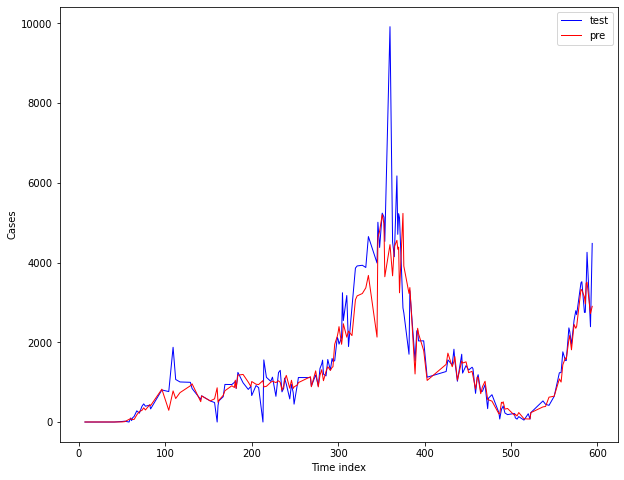

In [161]:
plt.figure(figsize=(10,8))
#plt.scatter(X_test['index'],y_test.values,label='test',facecolors='none',edgecolors='blue',linewidth=1)
#plt.scatter(X_test['index'],xgb_pre,label='pre',facecolors='none',edgecolors='red',linewidth=1)
#plt.plot(X_test['time'],y_test.values,label='test',c='blue',linewidth=1)
#plt.plot(X_test['time'],xgb_pre,label='pre',c='red',linewidth=1)

plt.plot(ans.index,ans['y_test'],label='test',c='blue',linewidth=1)
plt.plot(ans.index,ans['xgb_pre'],label='pre',c='red',linewidth=1)


plt.xlabel('Time index')
plt.ylabel('Cases')

plt.legend()

plt.close

## total death

In [63]:
y.columns

Index(['tot_cases', 'new_case', 'tot_death', 'new_death'], dtype='object')

In [64]:
X_train,X_test,y_train,y_test = train_test_split(X[:-60],y[y.columns[2]][60:],test_size=0.3,random_state=1024,shuffle=True)

train_x = X_train.copy()
target = pd.DataFrame(y_train.copy())
test_x = X_test.copy()

features = train_x.columns
feature_importance_df = pd.DataFrame()

In [65]:
#xgb
xlf=xgb.XGBRegressor(max_depth=8,
                     learning_rate=0.05,
                     n_estimators=1000,
                     )
answers = []
model = []
score = 0
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True,random_state=4096)
for fold_n, (train_index, valid_index) in enumerate(folds.split(train_x)):
    X_train, X_valid = train_x.iloc[train_index], train_x.iloc[valid_index]
    y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]
    
    xlf.fit(X_train,y_train,eval_set=[(X_valid, y_valid)],verbose=100,
    early_stopping_rounds=100)
    model.append(xlf)
    y_pre=xlf.predict(X_valid)
    #print('每一折验证分数:'+str(mean_squared_error(y_valid,y_pre)))
    print('每一折验证分数:'+str(mean_absolute_percentage_error(y_valid,y_pre)))
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = xlf.feature_importances_
    fold_importance_df["fold"] = fold_n + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    score = score + mean_absolute_percentage_error(y_valid,y_pre)
    y_pred_valid = xlf.predict(test_x)
    answers.append(y_pred_valid)
xgb_pre=sum(answers)/n_fold
print('xgb验证分数'+str(math.sqrt(score/n_fold)))
print(score/n_fold)

[18:00:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:6332.52
Will train until validation_0-rmse hasn't improved in 100 rounds.
[100]	validation_0-rmse:74.8656
[200]	validation_0-rmse:48.5484
[300]	validation_0-rmse:48.4958
Stopping. Best iteration:
[249]	validation_0-rmse:48.4636

每一折验证分数:0.019828982086791486
[18:00:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:7143.26
Will train until validation_0-rmse hasn't improved in 100 rounds.
[100]	validation_0-rmse:73.105
[200]	validation_0-rmse:37.5809
[300]	validation_0-rmse:36.9466
[400]	validation_0-rmse:36.9244
Stopping. Best iteration:
[355]	validation_0-rmse:36.9197

每一折验证分数:0.022699908015864412
[18:00:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:7160.1

In [66]:
total_death_model = model

In [67]:
dans = pd.DataFrame(y_test)
dans['y_test'] = dans['tot_death']
dans['xgb_pre'] = xgb_pre
dans.sort_index(inplace=True)

In [68]:
MAPE(dans[dans['y_test']!=0]['y_test'],dans[dans['y_test']!=0]['xgb_pre'])

0.01744531804365984

In [69]:
mean_absolute_percentage_error(y_test,xgb_pre),r2_score(y_test,xgb_pre),mean_squared_error(y_test,xgb_pre),mean_squared_error(y_test,xgb_pre)/np.average(y_test),mean_squared_error(y_test,xgb_pre,squared=False)/np.average(y_test)

(0.017445318043659834,
 0.9999005567183948,
 1638.0420342259756,
 0.26922374730470483,
 0.006651978606559193)

In [70]:
deathf = feature_importance_df.sort_values(by=['importance'],ascending=False)
deathf.to_csv('death_feature_importance.csv',index=True)

<function matplotlib.pyplot.close>

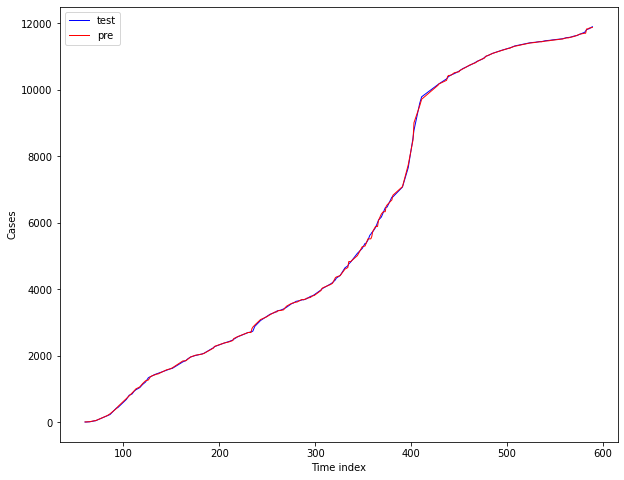

In [71]:
plt.figure(figsize=(10,8))
#plt.scatter(X_test['index'],y_test.values,label='test',facecolors='none',edgecolors='blue',linewidth=1)
#plt.scatter(X_test['index'],xgb_pre,label='pre',facecolors='none',edgecolors='red',linewidth=1)
#plt.plot(X_test['time'],y_test.values,label='test',c='blue',linewidth=1)
#plt.plot(X_test['time'],xgb_pre,label='pre',c='red',linewidth=1)

plt.plot(dans.index,dans['y_test'],label='test',c='blue',linewidth=1)
plt.plot(dans.index,dans['xgb_pre'],label='pre',c='red',linewidth=1)


plt.xlabel('Time index')
plt.ylabel('Cases')

plt.legend()

plt.close

## New death

In [202]:
X_train,X_test,y_train,y_test = train_test_split(X[:-7],y[y.columns[3]][7:],test_size=0.3,random_state=1024,shuffle=True)

train_x = X_train.copy()
target = pd.DataFrame(y_train.copy())
test_x = X_test.copy()

features = train_x.columns
feature_importance_df = pd.DataFrame()

In [203]:
#xgb
xlf=xgb.XGBRegressor(max_depth=8,
                     learning_rate=0.05,
                     n_estimators=1000,
                     )
answers = []
model = []
score = 0
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True,random_state=4096)
for fold_n, (train_index, valid_index) in enumerate(folds.split(train_x)):
    X_train, X_valid = train_x.iloc[train_index], train_x.iloc[valid_index]
    y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]
    
    xlf.fit(X_train,y_train,eval_set=[(X_valid, y_valid)],verbose=100,
    early_stopping_rounds=100)
    model.append(xlf)
    y_pre=xlf.predict(X_valid)
    #print('每一折验证分数:'+str(mean_squared_error(y_valid,y_pre)))
    print('每一折验证分数:'+str(mean_absolute_percentage_error(y_valid,y_pre)))
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = xlf.feature_importances_
    fold_importance_df["fold"] = fold_n + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    score = score + mean_absolute_percentage_error(y_valid,y_pre)
    y_pred_valid = xlf.predict(test_x)
    answers.append(y_pred_valid)
xgb_pre=sum(answers)/n_fold
print('xgb验证分数'+str(math.sqrt(score/n_fold)))
print(score/n_fold)

[13:41:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:36.7677
Will train until validation_0-rmse hasn't improved in 100 rounds.
[100]	validation_0-rmse:53.2092
Stopping. Best iteration:
[21]	validation_0-rmse:20.6412

每一折验证分数:1176469684582474.5
[13:41:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:38.4157
Will train until validation_0-rmse hasn't improved in 100 rounds.
[100]	validation_0-rmse:24.3834
[200]	validation_0-rmse:24.1966
Stopping. Best iteration:
[167]	validation_0-rmse:24.1655

每一折验证分数:3666903075297847.5
[13:41:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:28.375
Will train until validation_0-rmse hasn't improved in 100 rounds.
[100]	validation_0-rmse:23.0745
Stopping. Best iteration:
[31]	va

In [204]:
new_death_model = model

In [206]:
ans = pd.DataFrame(y_test)
ans['y_test'] = ans['new_death']
ans['xgb_pre'] = xgb_pre
ans.sort_index(inplace=True)

In [207]:
MAPE(ans[ans['y_test']!=0]['y_test'],ans[ans['y_test']!=0]['xgb_pre'])

0.6735738004767639

In [208]:
mean_absolute_percentage_error(y_test,xgb_pre),r2_score(y_test,xgb_pre),mean_squared_error(y_test,xgb_pre),mean_squared_error(y_test,xgb_pre)/np.average(y_test),mean_squared_error(y_test,xgb_pre,squared=False)/np.average(y_test)

(813164524705907.6, 0.6891019250300443, 10.762359114555762, 0.764817979121875)

In [209]:
ndeathf = feature_importance_df.sort_values(by=['importance'],ascending=False)
ndeathf.to_csv('new_death_feature_importance.csv',index=True)

<function matplotlib.pyplot.close>

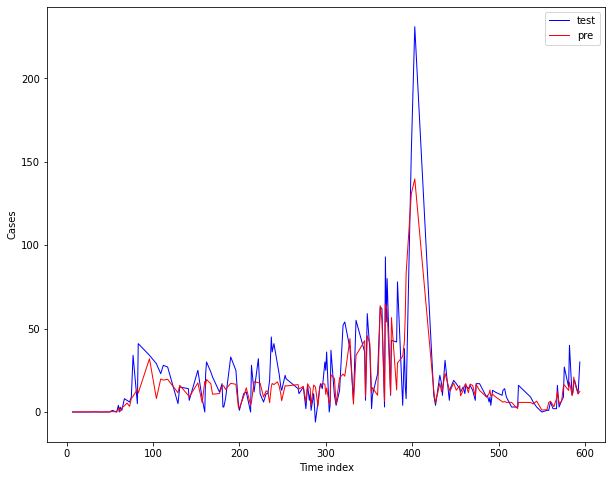

In [210]:
plt.figure(figsize=(10,8))
#plt.scatter(X_test['index'],y_test.values,label='test',facecolors='none',edgecolors='blue',linewidth=1)
#plt.scatter(X_test['index'],xgb_pre,label='pre',facecolors='none',edgecolors='red',linewidth=1)
#plt.plot(X_test['time'],y_test.values,label='test',c='blue',linewidth=1)
#plt.plot(X_test['time'],xgb_pre,label='pre',c='red',linewidth=1)

plt.plot(ans.index,ans['y_test'],label='test',c='blue',linewidth=1)
plt.plot(ans.index,ans['xgb_pre'],label='pre',c='red',linewidth=1)


plt.xlabel('Time index')
plt.ylabel('Cases')

plt.legend()

plt.close

## Slinding window for total case

In [55]:
#X[:-7],y[y.columns[0]][7:]

In [162]:
# create the dataframe for sliding window use
window_df = X[:-7]
window_df['tot_cases'] = y[y.columns[0]][7:].values

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [180]:
#trained by sliding window
window = 60
pre_window = 14
wscore = 0
wanswers = []
wtest = pd.DataFrame()

for i in np.arange(window,np.shape(X[:-7])[0])[::pre_window]:
  window_train = window_df[i-window:i].sample(frac=1) #shuffle the dataframe
  wtrain_x = window_train.drop(columns=['tot_cases'])
  wtrain_y = window_train['tot_cases']

  window_test = window_df[i:i+pre_window]
  wtest_x = window_test.drop(columns=['tot_cases'])
  wtest_y = window_test['tot_cases']

  #xgb
  xlf=xgb.XGBRegressor(max_depth=8,
                      learning_rate=0.05,
                      n_estimators=1000,
                      )
      
  xlf.fit(wtrain_x,wtrain_y)
  xgb_pre=xlf.predict(wtest_x)
  wanswers += xgb_pre.tolist()
  wtest = pd.concat([pd.DataFrame(wtest),pd.DataFrame(wtest_y)], axis=0)

[13:26:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:26:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:26:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:26:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:26:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:26:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:26:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:26:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [170]:
mean_absolute_percentage_error(wtest,wanswers),r2_score(wtest,wanswers),mean_squared_error(wtest,wanswers)/np.average(wtest),mean_squared_error(wtest,wanswers,squared=False)/np.average(wtest)

(0.08613313640597074,
 0.9962201716955017,
 766.8042026716212,
 0.04595255086572418)

In [176]:
MAPE(wtest['tot_cases'],wanswers)

0.0861331364059708

In [182]:
wans = pd.DataFrame(wtest.copy())
wans['y_test'] = wans['tot_cases']
wans['xgb_pre'] = wanswers
wans.sort_index(inplace=True)

<function matplotlib.pyplot.close>

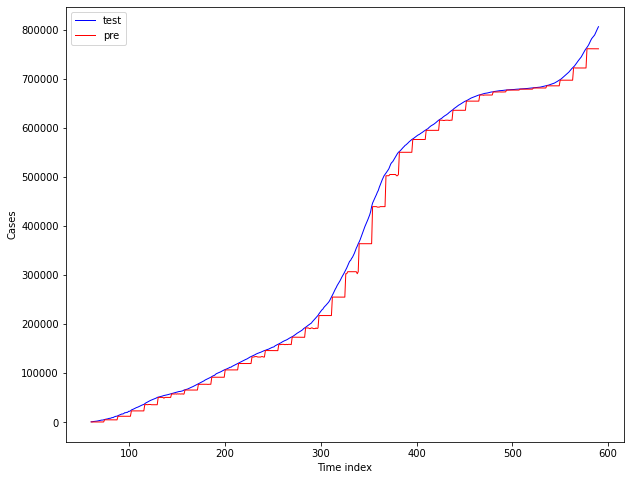

In [217]:
plt.figure(figsize=(10,8))
#plt.scatter(X_test['index'],y_test.values,label='test',facecolors='none',edgecolors='blue',linewidth=1)
#plt.scatter(X_test['index'],xgb_pre,label='pre',facecolors='none',edgecolors='red',linewidth=1)
#plt.plot(X_test['time'],y_test.values,label='test',c='blue',linewidth=1)
#plt.plot(X_test['time'],xgb_pre,label='pre',c='red',linewidth=1)

plt.plot(wans.index,wans['y_test'],label='test',c='blue',linewidth=1)
plt.plot(wans.index,wans['xgb_pre'],label='pre',c='red',linewidth=1)


plt.xlabel('Time index')
plt.ylabel('Cases')

plt.legend()

plt.close

## Sliding window for new case

In [184]:
window_df = X[:-7]
window_df['new_cases'] = y[y.columns[1]][7:].values

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [185]:
#trained by sliding window
window = 60
pre_window = 14
wscore = 0
wanswers = []
wtest = pd.DataFrame()

for i in np.arange(window,np.shape(X[:-7])[0])[::pre_window]:
  window_train = window_df[i-window:i].sample(frac=1) #shuffle the dataframe
  wtrain_x = window_train.drop(columns=['new_case'])
  wtrain_y = window_train['new_case']

  window_test = window_df[i:i+pre_window]
  wtest_x = window_test.drop(columns=['new_case'])
  wtest_y = window_test['new_case']

  #xgb
  xlf=xgb.XGBRegressor(max_depth=8,
                      learning_rate=0.05,
                      n_estimators=1000,
                      )
      
  xlf.fit(wtrain_x,wtrain_y)
  xgb_pre=xlf.predict(wtest_x)
  wanswers += xgb_pre.tolist()
  wtest = pd.concat([pd.DataFrame(wtest),pd.DataFrame(wtest_y)], axis=0)

[13:27:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:27:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:27:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:27:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:27:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:27:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:27:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:27:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [186]:
mean_absolute_percentage_error(wtest,wanswers),r2_score(wtest,wanswers),mean_squared_error(wtest,wanswers)/np.average(wtest),mean_squared_error(wtest,wanswers,squared=False)/np.average(wtest)

(2.2358494585609668e+16,
 0.741258385424679,
 324.0416595747759,
 0.4691992981772516)

In [189]:
MAPE(wtest['new_case'],wanswers)

inf

In [190]:
wans = pd.DataFrame(wtest.copy())
wans['y_test'] = wans['new_case']
wans['xgb_pre'] = wanswers
wans.sort_index(inplace=True)

In [191]:
MAPE(wans[wans['y_test']!=0]['y_test'],wans[wans['y_test']!=0]['xgb_pre'])

0.35922882948365464

<function matplotlib.pyplot.close>

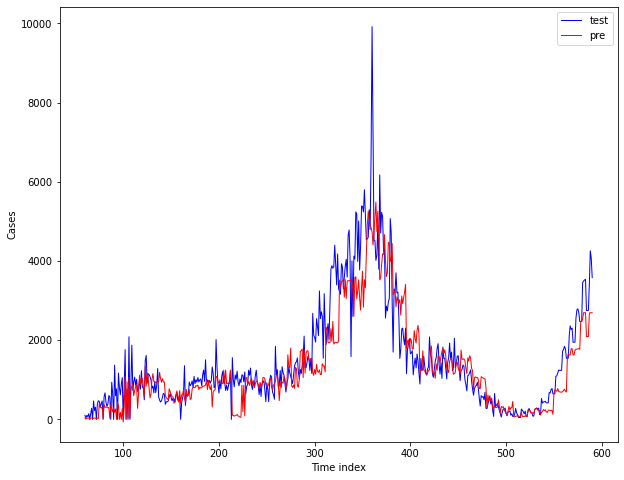

In [227]:
plt.figure(figsize=(10,8))
#plt.scatter(X_test['index'],y_test.values,label='test',facecolors='none',edgecolors='blue',linewidth=1)
#plt.scatter(X_test['index'],xgb_pre,label='pre',facecolors='none',edgecolors='red',linewidth=1)
#plt.plot(X_test['time'],y_test.values,label='test',c='blue',linewidth=1)
#plt.plot(X_test['time'],xgb_pre,label='pre',c='red',linewidth=1)

plt.plot(wans.index,wans['y_test'],label='test',c='blue',linewidth=1)
plt.plot(wans.index,wans['xgb_pre'],label='pre',c='red',linewidth=1)


plt.xlabel('Time index')
plt.ylabel('Cases')

plt.legend()

plt.close

## Estimate existing cases

In [72]:
#total cases - total death - total recovered
#new cases - new death - new recovered + last day existing

In [73]:
# re_df[60:315]
# re_X[:-7],re_y[re_y.columns[0]][7:]
# accumulated_recovered_model=model

# df[143:398]
# X[:-7],y[y.columns[0]][7:]
# total_model = model

# X[:-7],y[y.columns[2]][7:]
# total_death_model = model

In [74]:
#using stored models before to prdict the values on combined test data which is according to the date range of recover data
er = []
for i in range(len(accumulated_recovered_model)):
  existing_recover = accumulated_recovered_model[i].predict(re_X[60-60:315-60])
  er.append(existing_recover)
final_er = sum(er)/5

et = []
for i in range(len(total_model)):
  existing_total = total_model[i].predict(X[143-60:398-60])
  et.append(existing_total)
final_et = sum(et)/5

ed = []
for i in range(len(total_death_model)):
  existing_death = total_death_model[i].predict(X[143-60:398-60])
  ed.append(existing_death)
final_ed = sum(ed)/5

In [75]:
pre_existing = final_et-final_er-final_ed

In [76]:
existing = y[y.columns[0]][143:398]-y[y.columns[2]][143:398]-re_y[re_y.columns[0]][60:315].values

In [77]:
# import the prediction by SIR model
SIR = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/STATS_402/SIR_result.csv')

In [78]:
SIR.dropna()

date  ...  reduced case (real)
63   2020/6/16  ...               9012.0
64   2020/6/17  ...               9079.0
65   2020/6/18  ...               9165.0
66   2020/6/19  ...               9214.0
67   2020/6/20  ...               9257.0
..         ...  ...                  ...
310  2021/2/18  ...              52622.0
311  2021/2/19  ...              52864.0
312  2021/2/20  ...              53077.0
313  2021/2/21  ...              53378.0
314  2021/2/22  ...              53378.0

[252 rows x 5 columns]

<function matplotlib.pyplot.close>

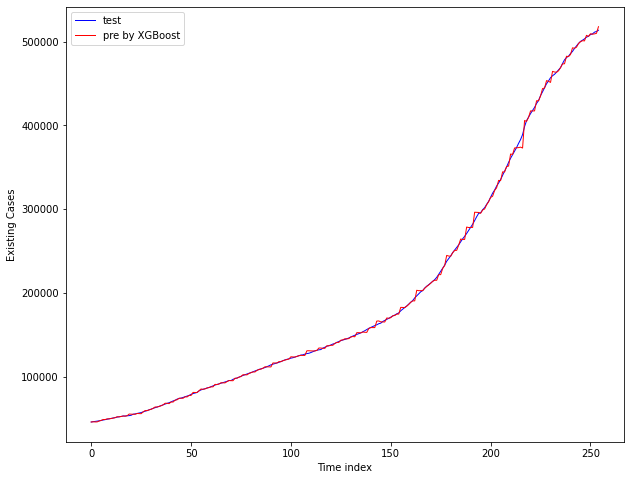

In [79]:
plt.figure(figsize=(10,8))
#plt.scatter(X_test['index'],y_test.values,label='test',facecolors='none',edgecolors='blue',linewidth=1)
#plt.scatter(X_test['index'],xgb_pre,label='pre',facecolors='none',edgecolors='red',linewidth=1)
#plt.plot(X_test['time'],y_test.values,label='test',c='blue',linewidth=1)
#plt.plot(X_test['time'],xgb_pre,label='pre',c='red',linewidth=1)

plt.plot(np.arange(len(pre_existing)),existing,label='test',c='blue',linewidth=1)
plt.plot(np.arange(len(pre_existing)),pre_existing,label='pre by XGBoost',c='red',linewidth=1)

plt.xlabel('Time index')
plt.ylabel('Existing Cases')

plt.legend()

plt.close

In [87]:
mean_absolute_percentage_error(existing,pre_existing),r2_score(existing,pre_existing),mean_squared_error(existing,pre_existing),mean_squared_error(existing,pre_existing)/np.average(existing),mean_squared_error(existing,pre_existing,squared=False)/np.average(existing)

(0.006662188250970697,
 0.9997279042892763,
 5301608.447112499,
 26.818111133102157,
 0.011647275852566542)

<function matplotlib.pyplot.close>

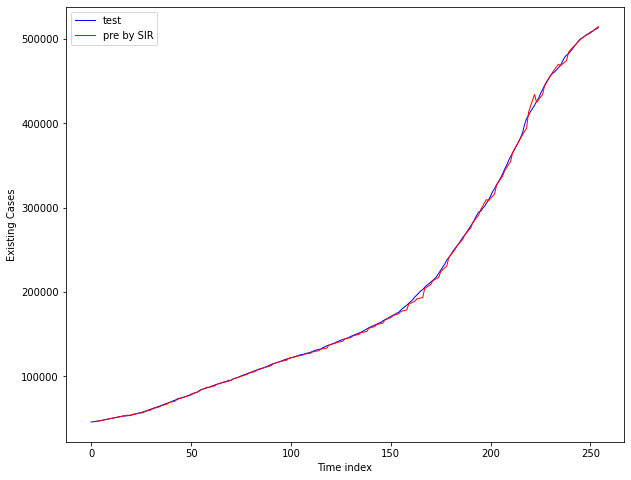

In [81]:
plt.figure(figsize=(10,8))
#plt.scatter(X_test['index'],y_test.values,label='test',facecolors='none',edgecolors='blue',linewidth=1)
#plt.scatter(X_test['index'],xgb_pre,label='pre',facecolors='none',edgecolors='red',linewidth=1)
#plt.plot(X_test['time'],y_test.values,label='test',c='blue',linewidth=1)
#plt.plot(X_test['time'],xgb_pre,label='pre',c='red',linewidth=1)

plt.plot(np.arange(len(pre_existing)),existing,label='test',c='blue',linewidth=1)
#plt.plot(np.arange(len(pre_existing)),pre_existing,label='pre by XGBoost',c='red',linewidth=1)
plt.plot(np.arange(3,len(pre_existing)),SIR['existing case (predicted)'][63:],label='pre by SIR',c='red',linewidth=1)

plt.xlabel('Time index')
plt.ylabel('Existing Cases')

plt.legend()

plt.close

In [82]:
mean_absolute_percentage_error(existing[3:],SIR['existing case (predicted)'][63:]),r2_score(existing[3:],SIR['existing case (predicted)'][63:]),mean_squared_error(existing[3:],SIR['existing case (predicted)'][63:]),mean_squared_error(existing[3:],SIR['existing case (predicted)'][63:])/np.average(existing[3:]),mean_squared_error(existing[3:],SIR['existing case (predicted)'][63:],squared=False)/np.average(existing[3:])

(0.00713651465983423,
 0.9996875480043755,
 6073990.575555562,
 30.44738468501227,
 0.012354151916228295)

In [83]:
re_hos = hos.drop(columns=['PPE','Capacity','Surge Capacity','Beds Occupied'])

In [86]:
er = []
for i in range(len(accumulated_recovered_model)):
  existing_recover = accumulated_recovered_model[i].predict(re_X[60-60:315-60])
  er.append(existing_recover)
final_er = sum(er)/5

et = []
for i in range(len(total_model)):
  existing_total = total_model[i].predict(X[143-60:398-60])
  et.append(existing_total)
final_et = sum(et)/5

ed = []
for i in range(len(total_death_model)):
  existing_death = total_death_model[i].predict(X[143-60:398-60])
  ed.append(existing_death)
final_ed = sum(ed)/5

## df = case+intervention train-test comparison

In [ ]:
#pip install sweetviz

In [ ]:
import sweetviz as sv

In [ ]:
sweet = df.drop(columns = ['conf_cases', 'prob_cases', 'pnew_case', 'conf_death', 'prob_death', 'pnew_death',
                         'created_at', 'consent_cases', 'consent_deaths','Date','C5_Close public transport','E3_Fiscal measures','E4_International support',
                         'H4_Emergency investment in healthcare', 'H5_Investment in vaccines','ConfirmedCases', 'ConfirmedDeaths','date'])

In [ ]:
sweet_train,sweet_test = train_test_split(sweet,test_size=0.2,shuffle=False)

In [ ]:
my_report = sv.compare([sweet_train, "Training Data"], [sweet_test, "Test Data"], "new_case")

                                             |          | [  0%]   00:00 -> (? left)

In [ ]:
np.where(df.new_death==-90)

(array([421]),)


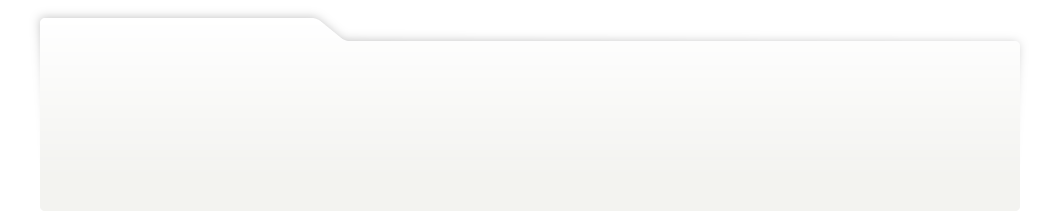
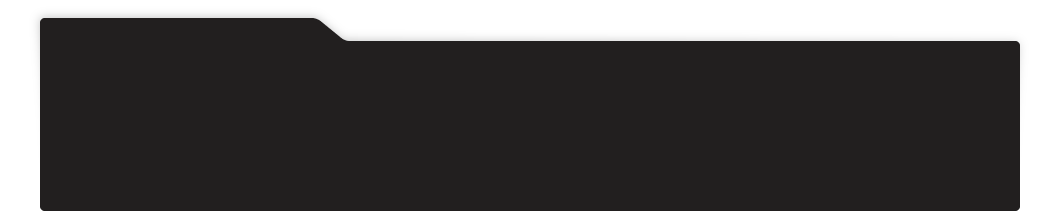
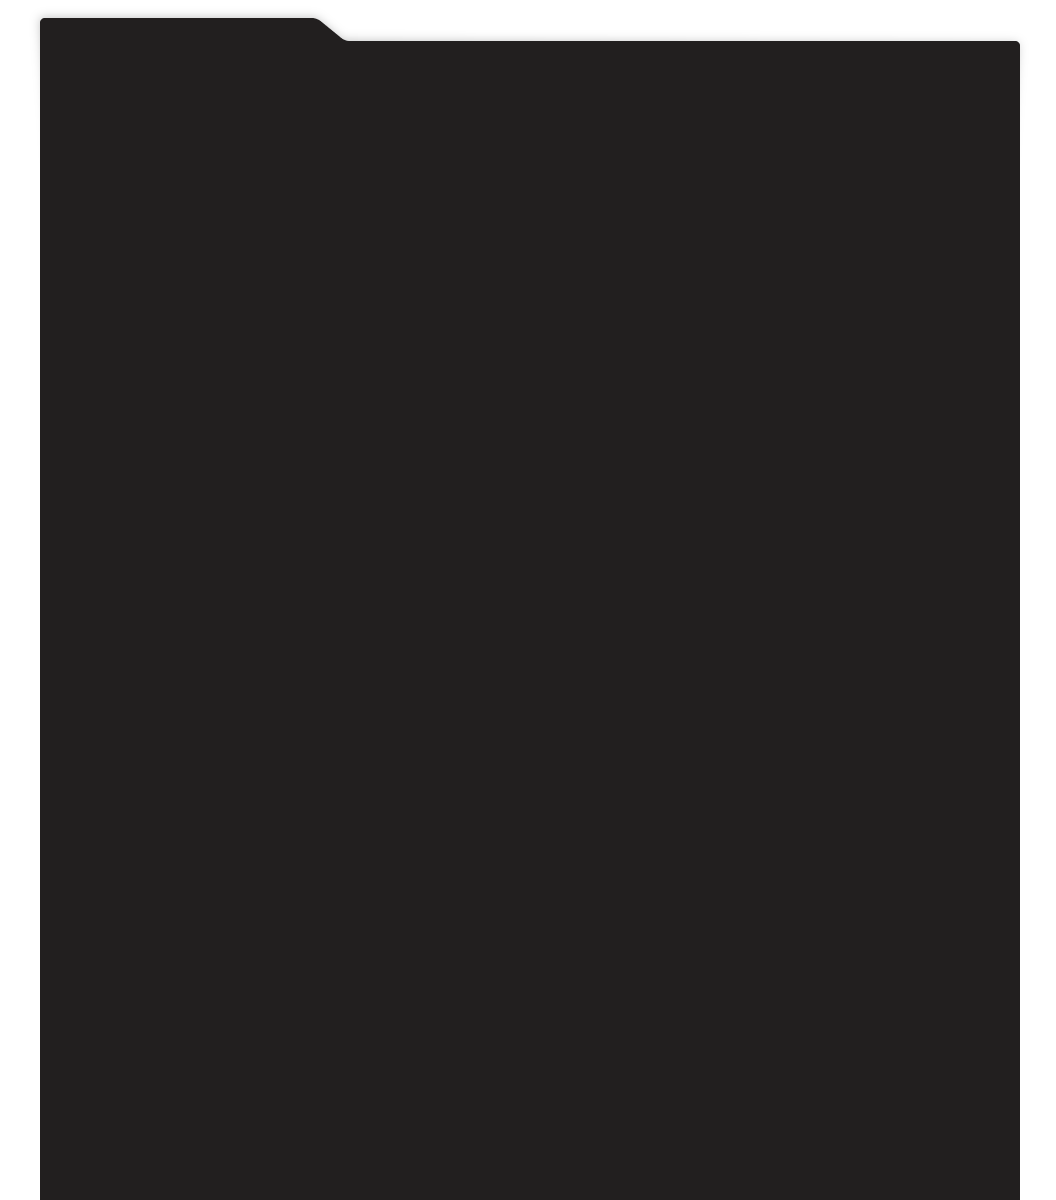
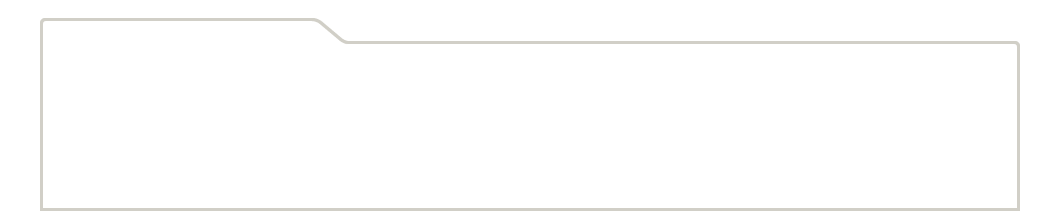
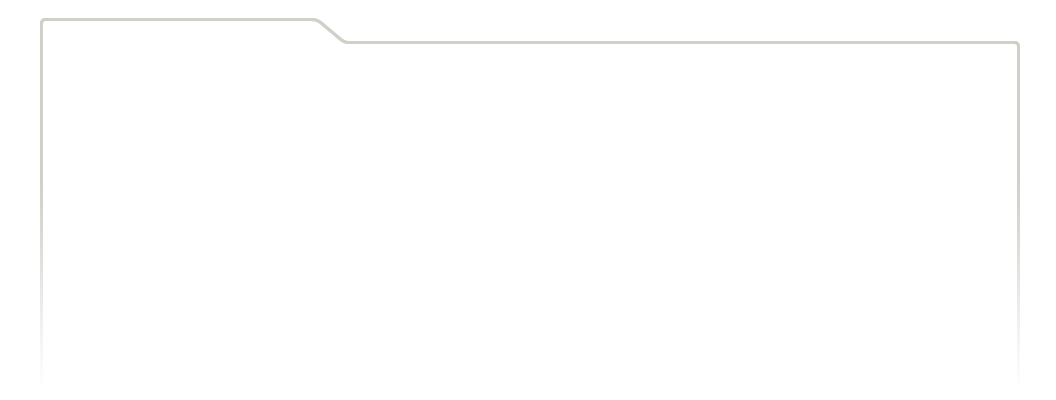
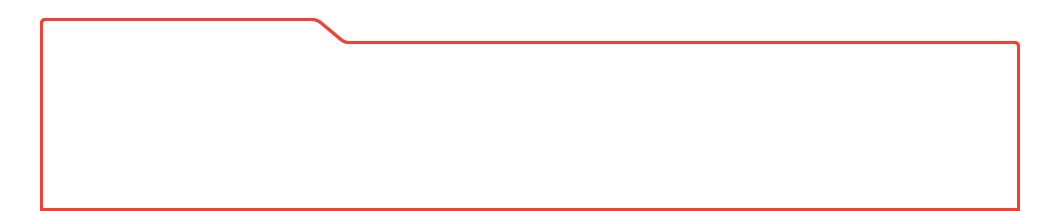
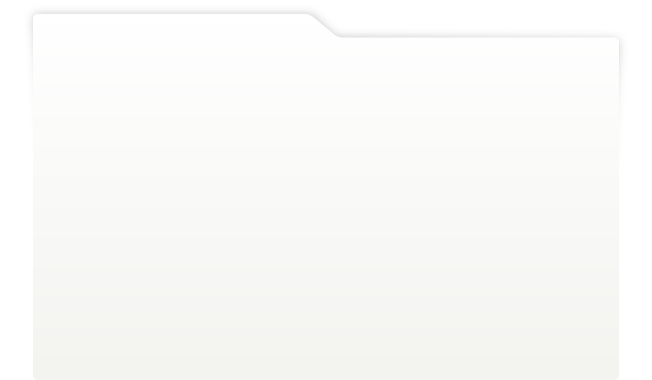
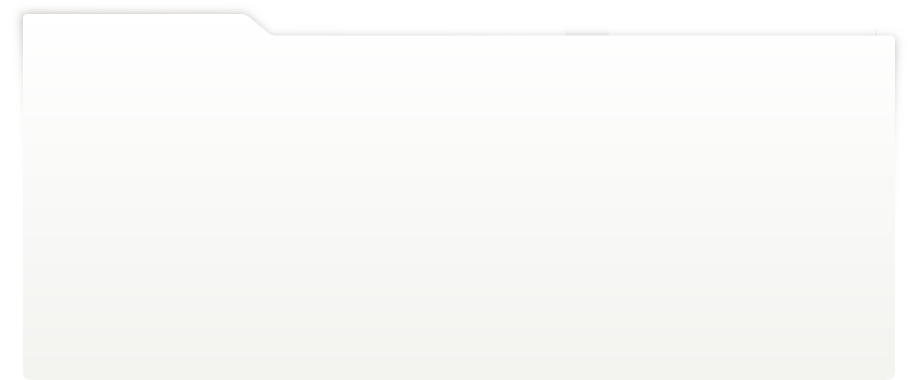
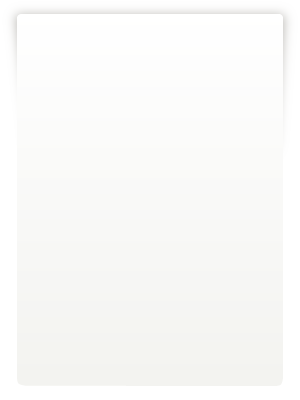
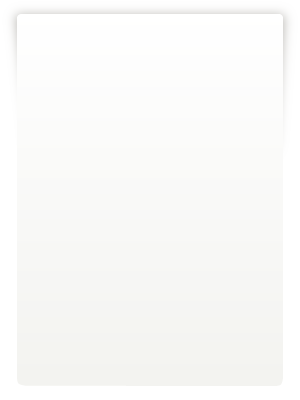
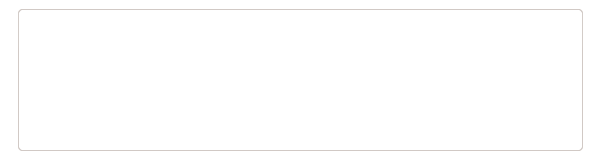
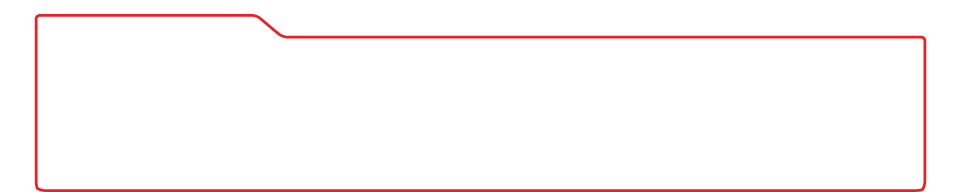
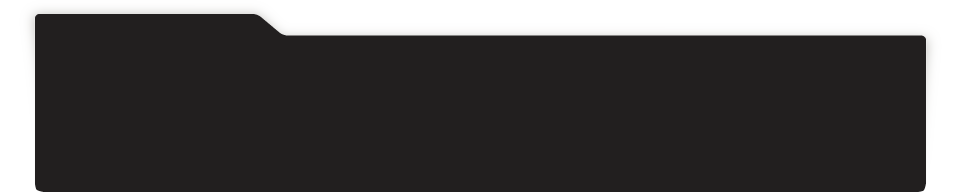
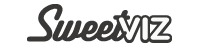
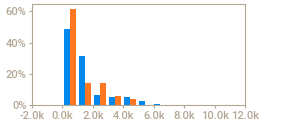
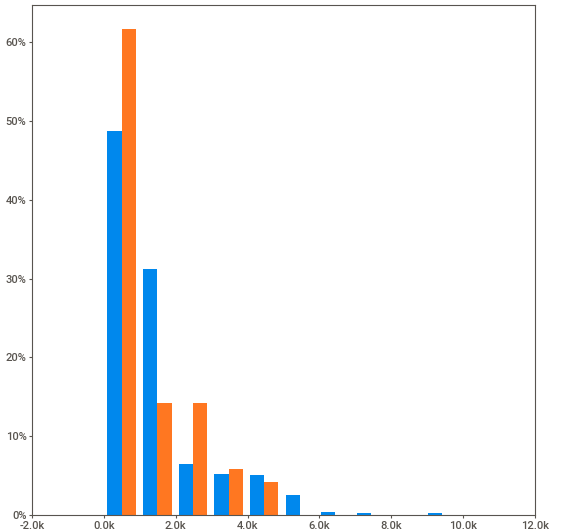
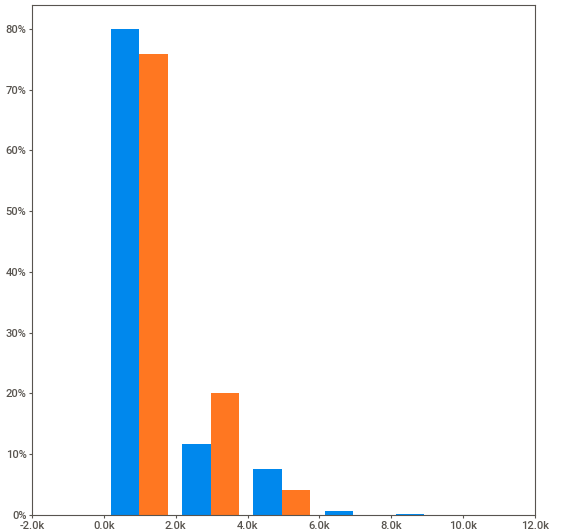
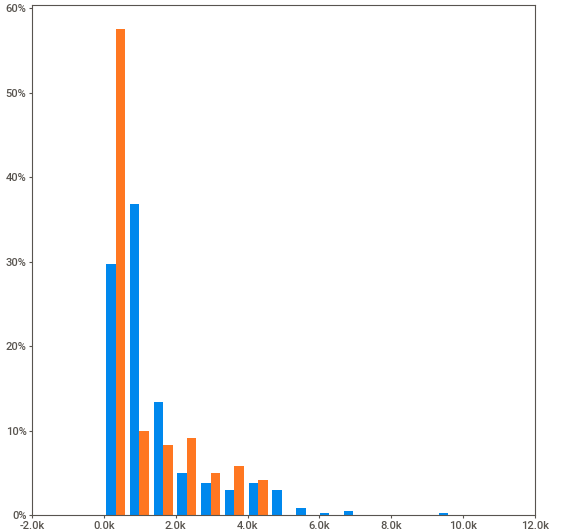
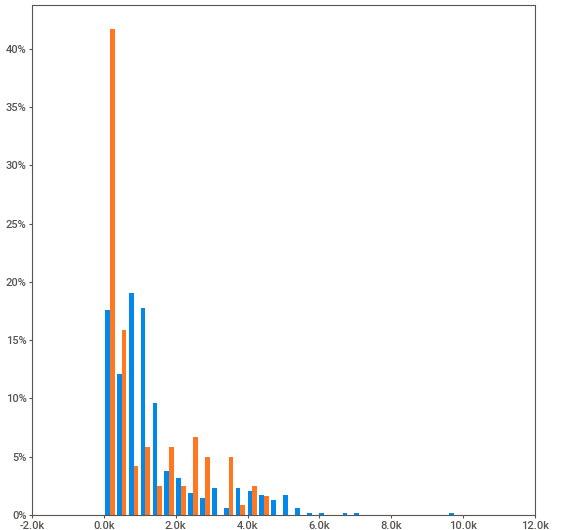
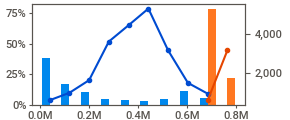
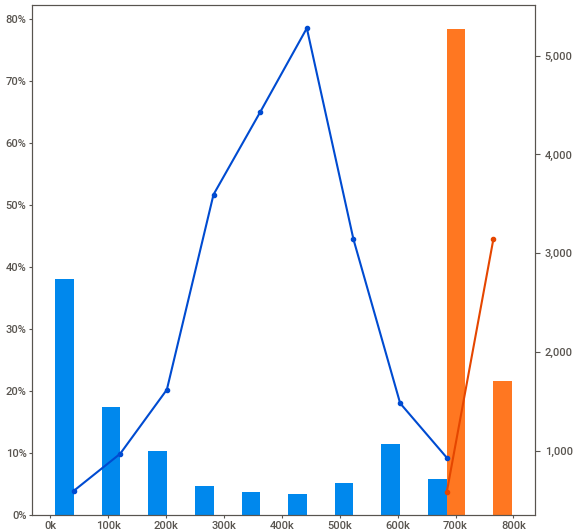
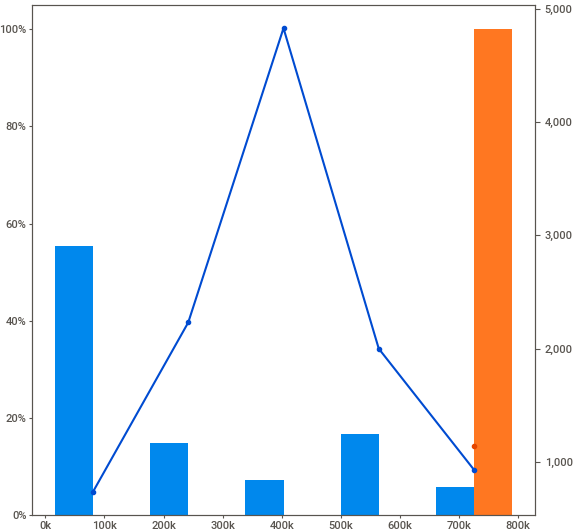
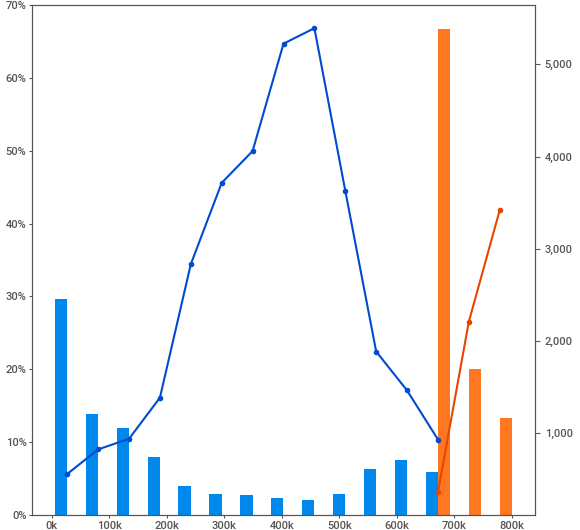
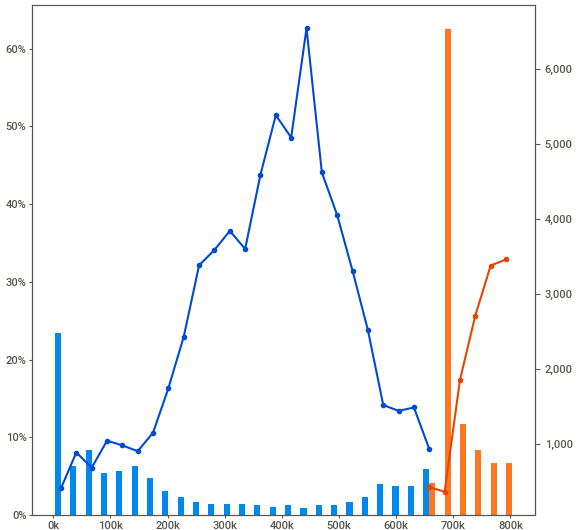
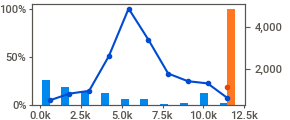
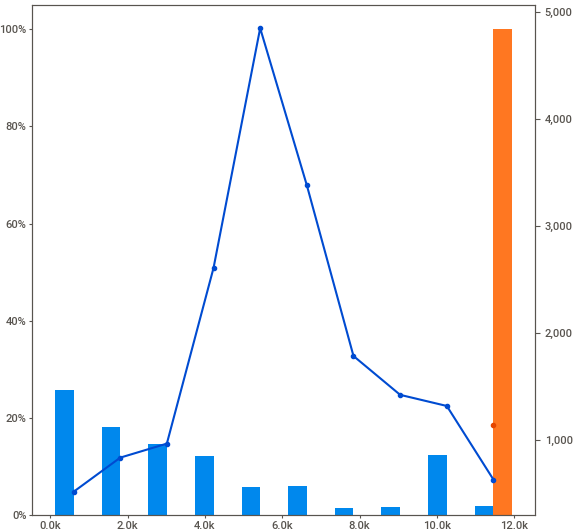
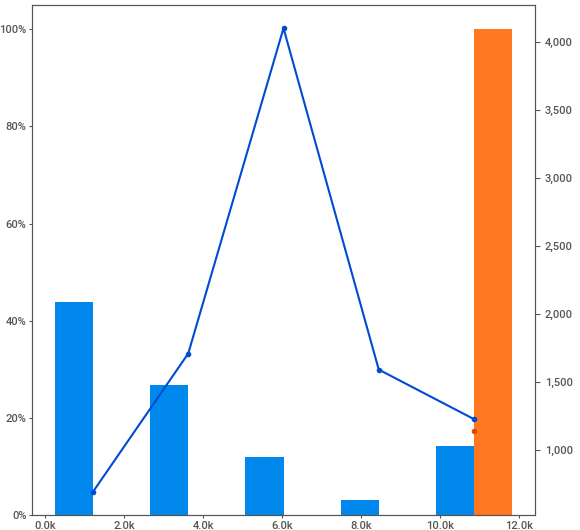
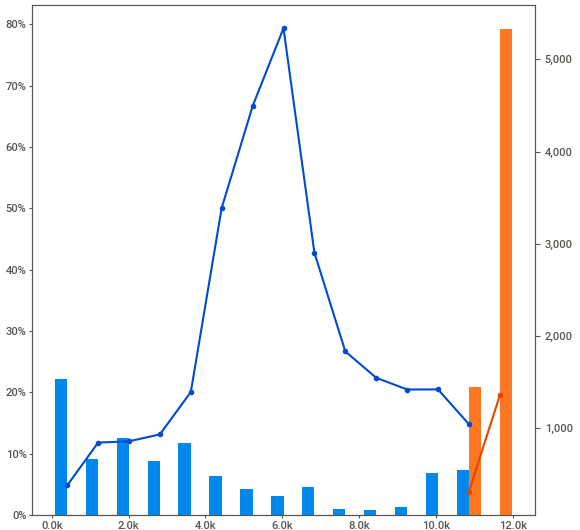
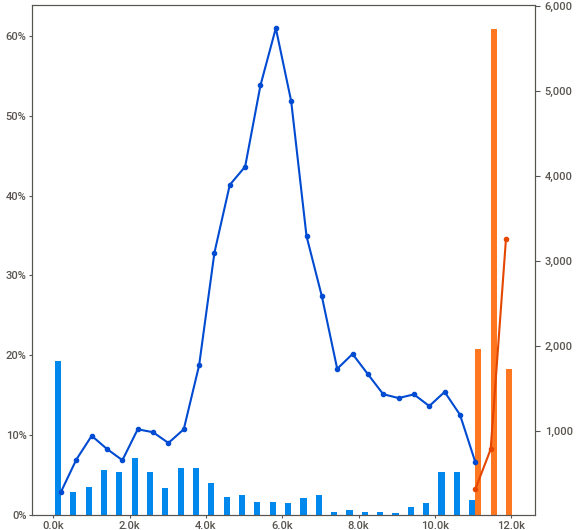
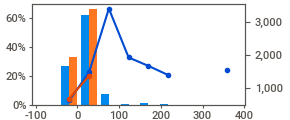
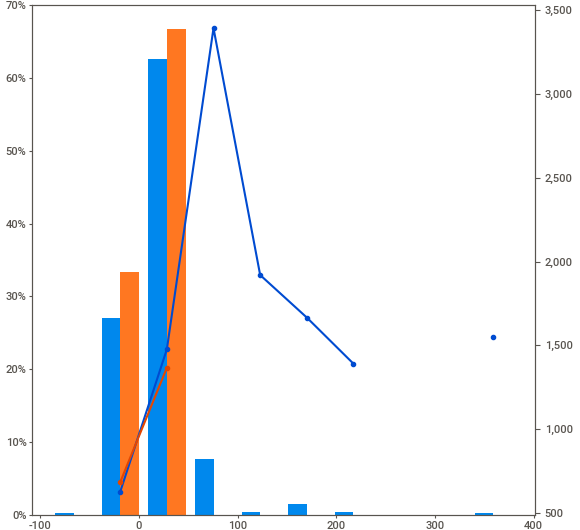
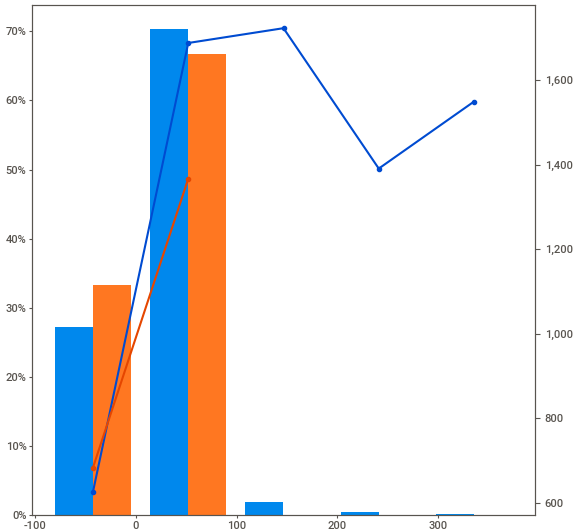
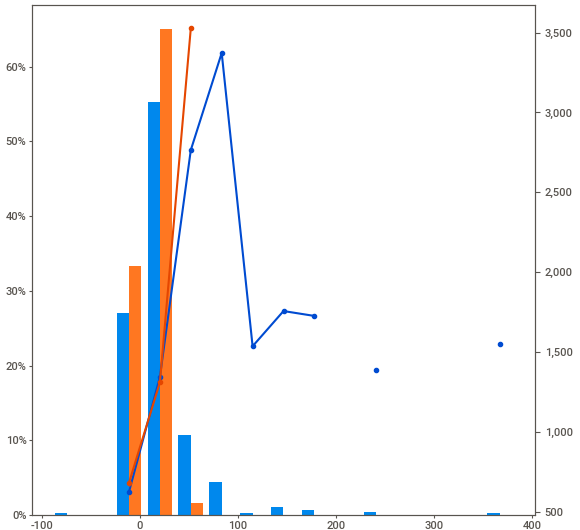
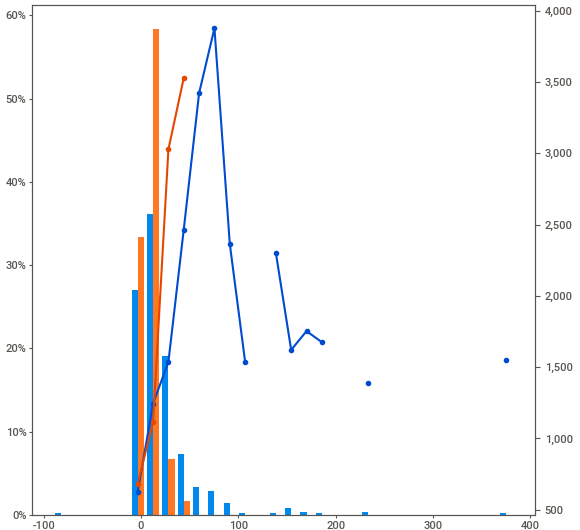
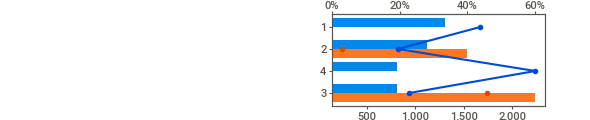
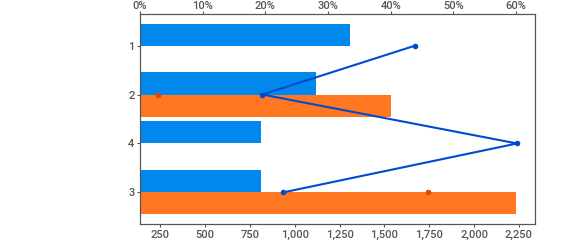
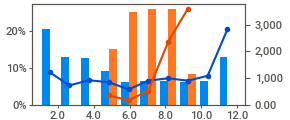
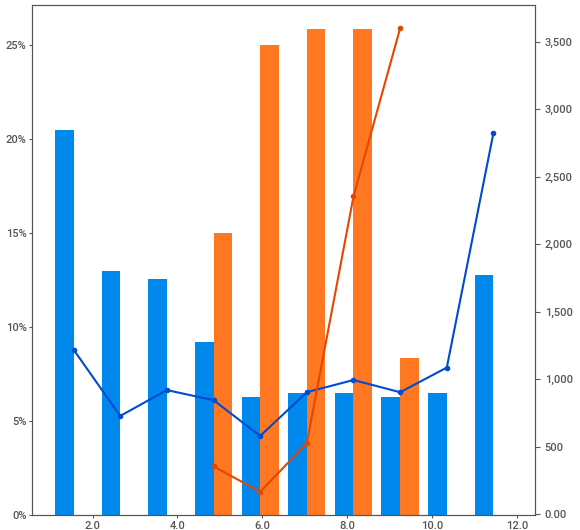
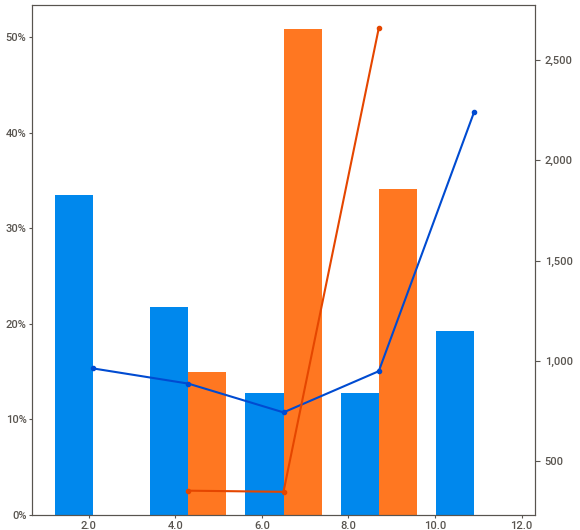
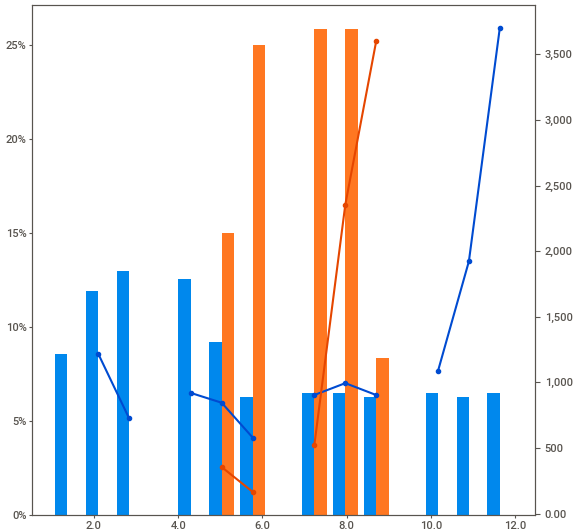
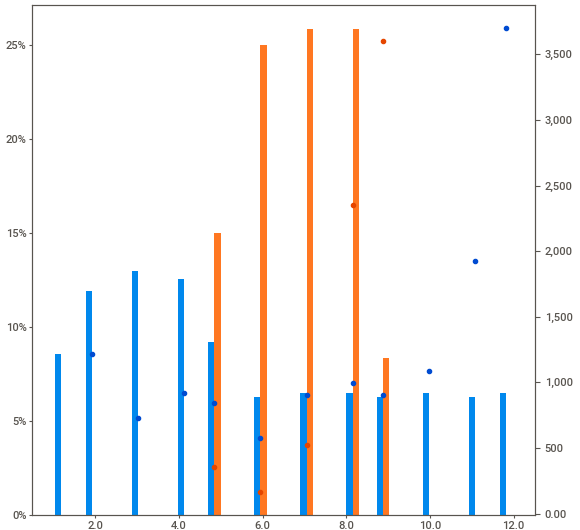
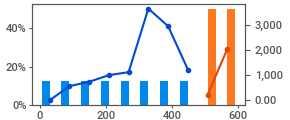
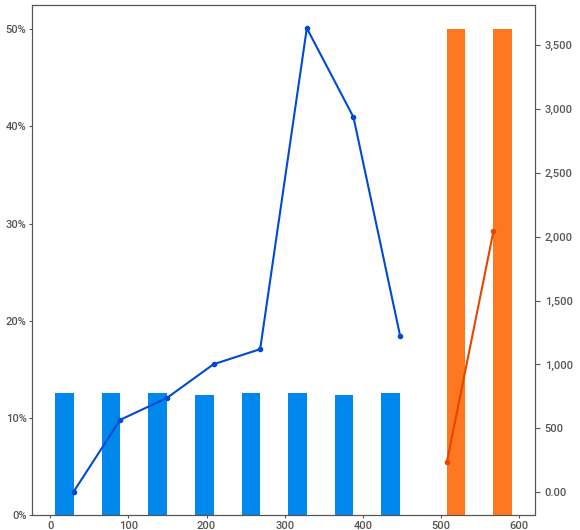
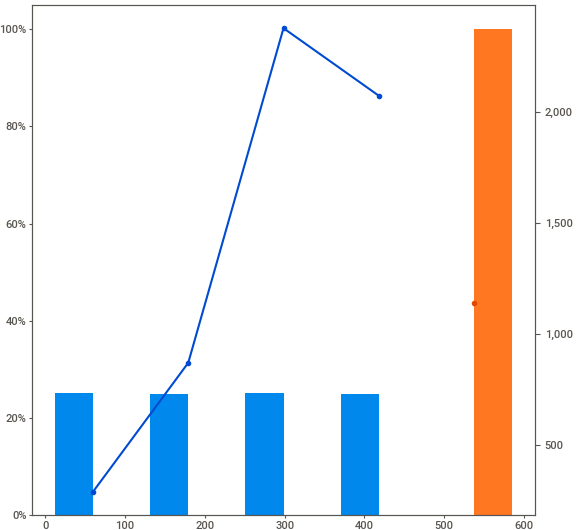
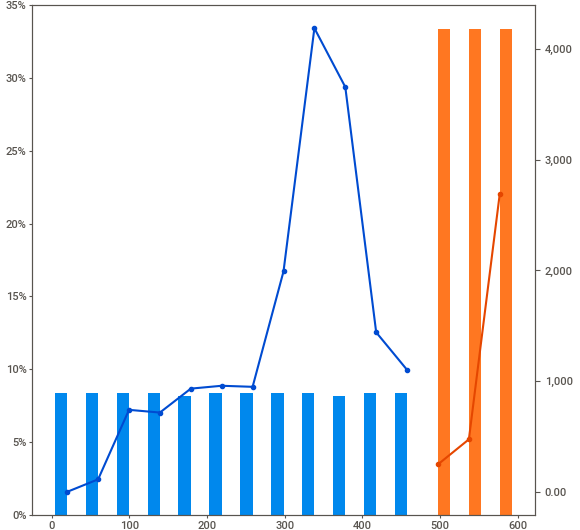
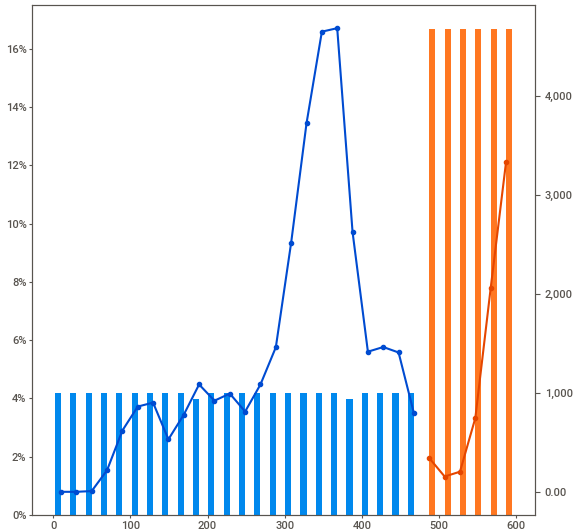
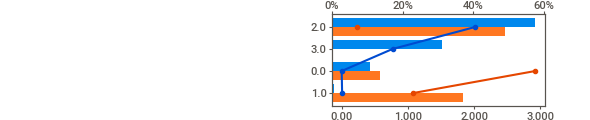
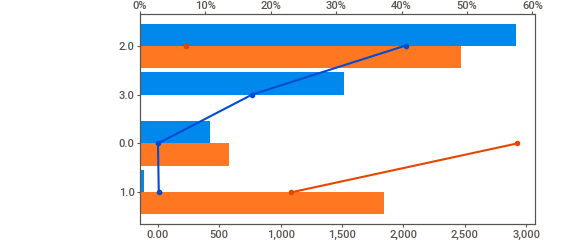
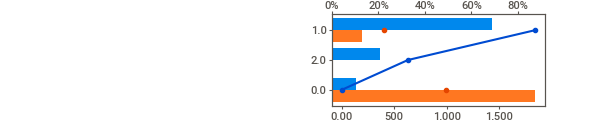
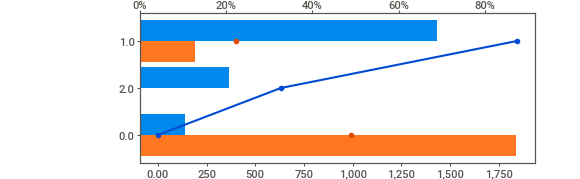
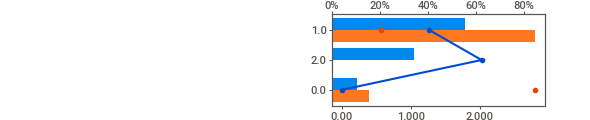
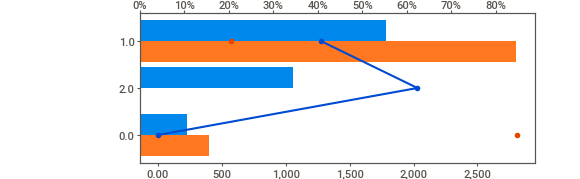
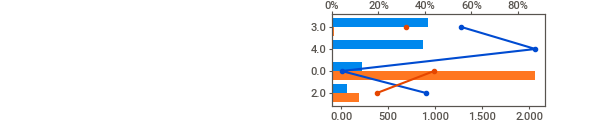
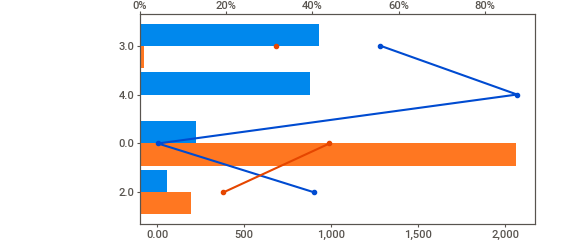
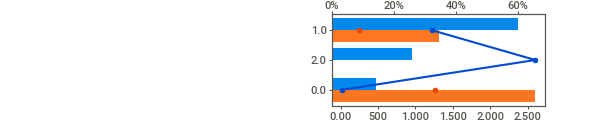
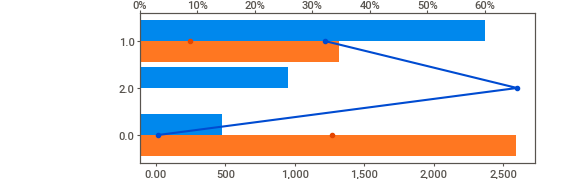
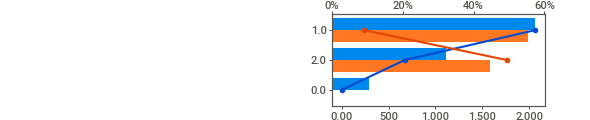
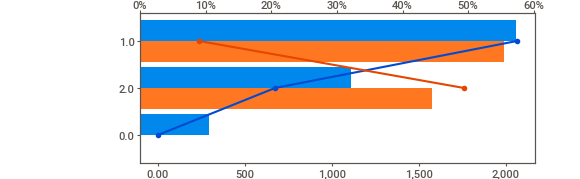
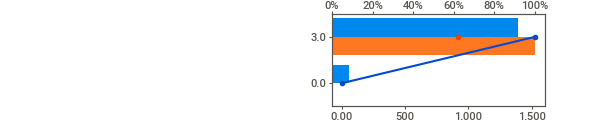
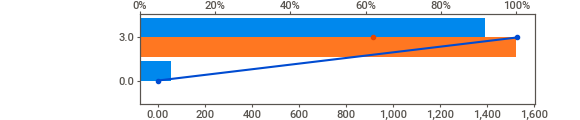
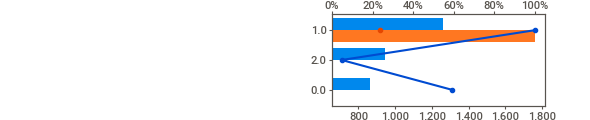
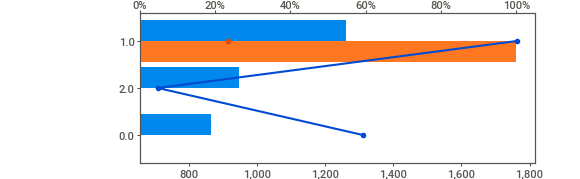
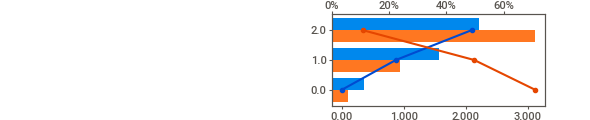
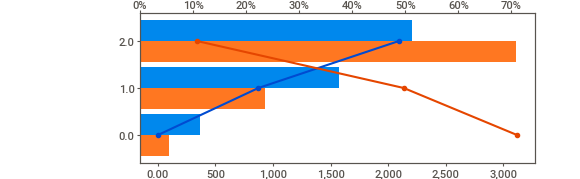
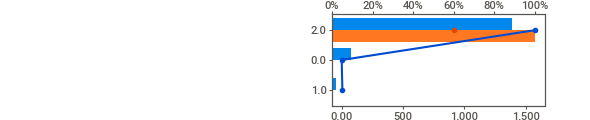
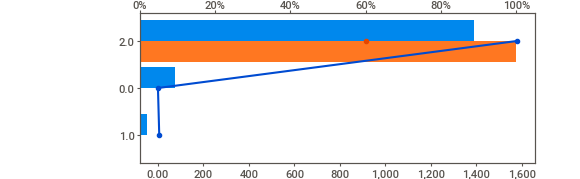
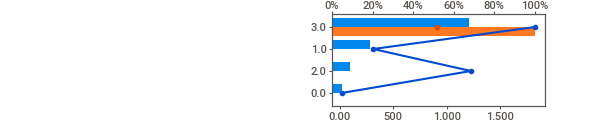
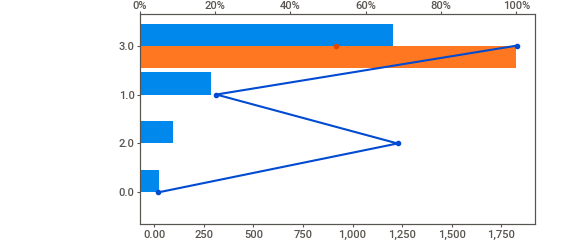
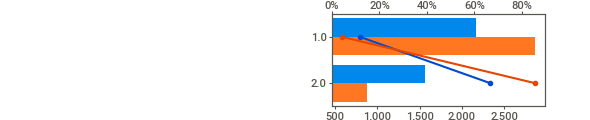
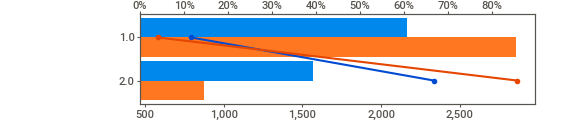
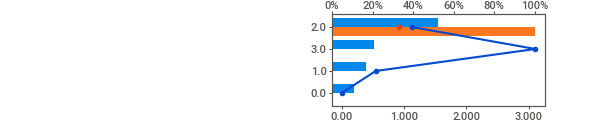
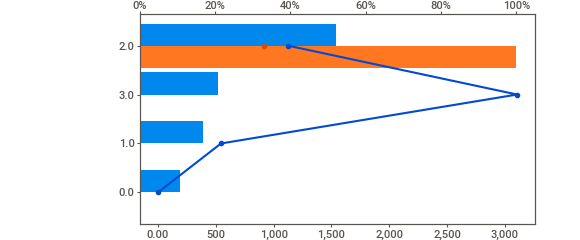
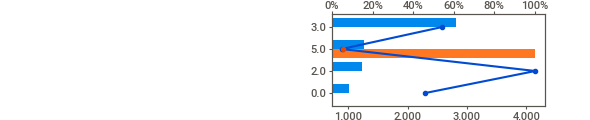
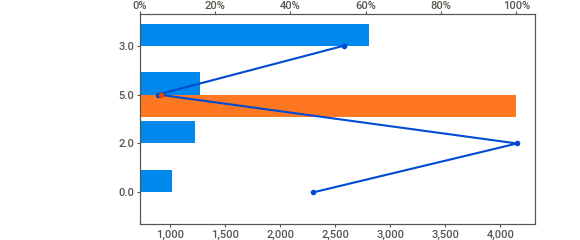
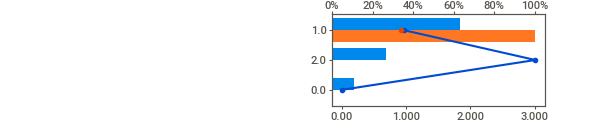
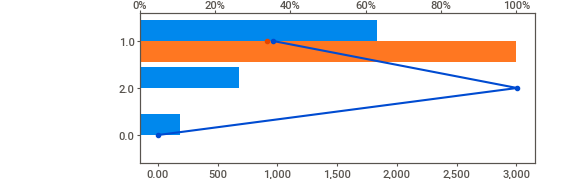
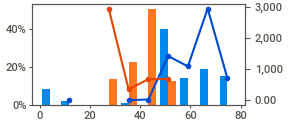
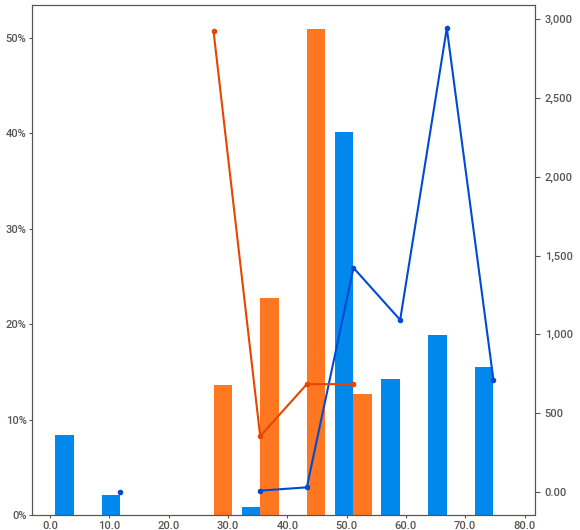
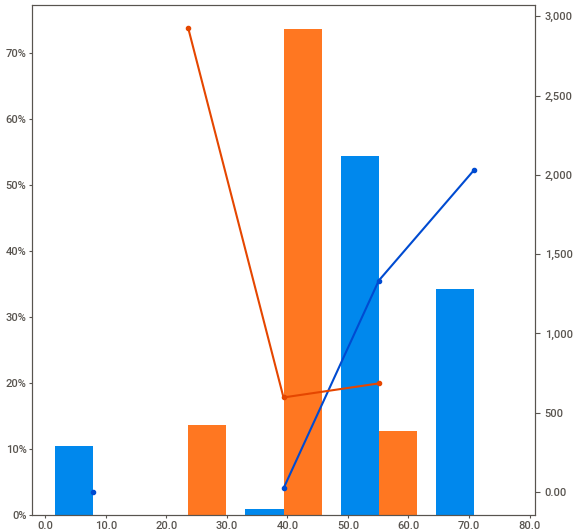
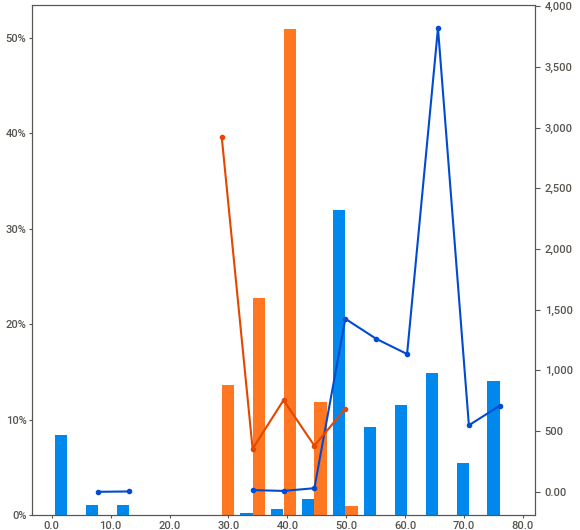
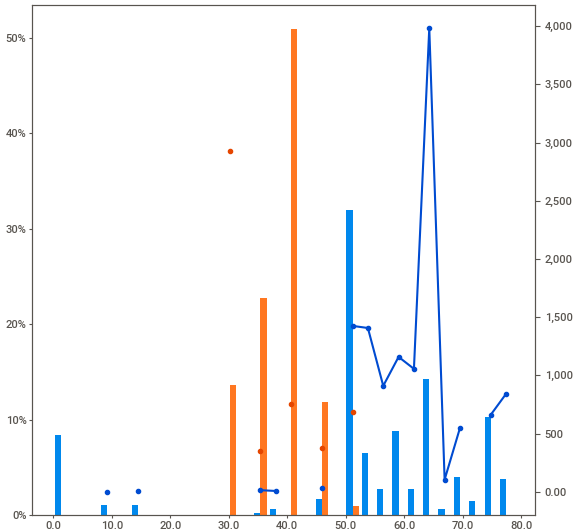
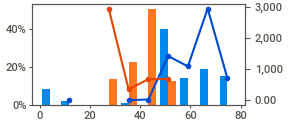
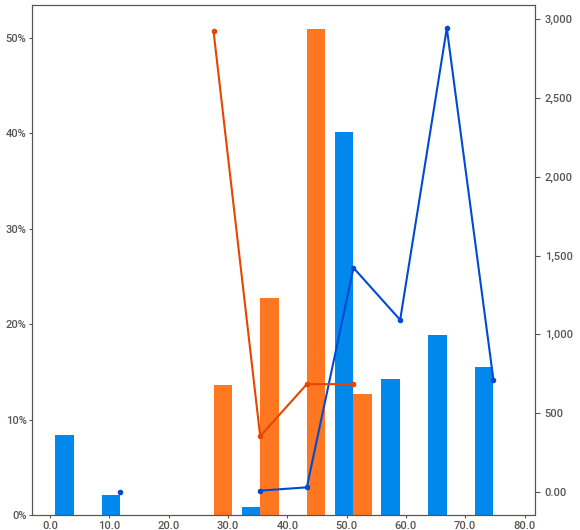
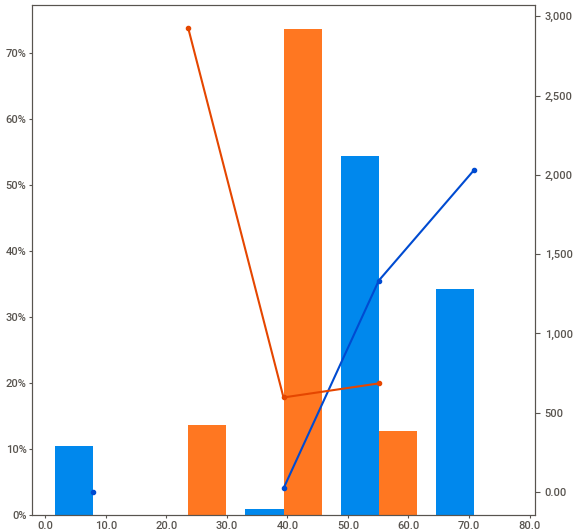
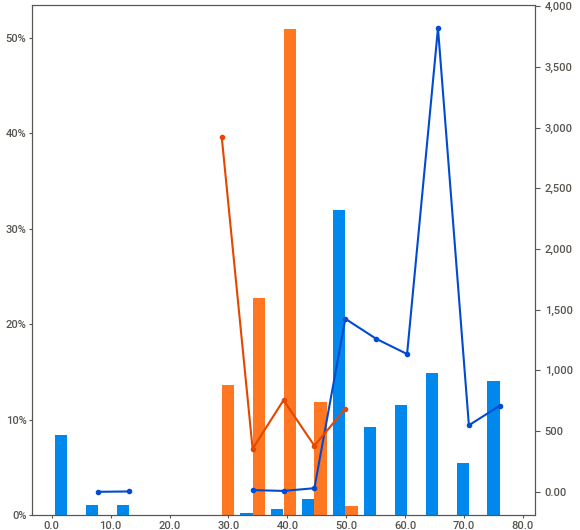
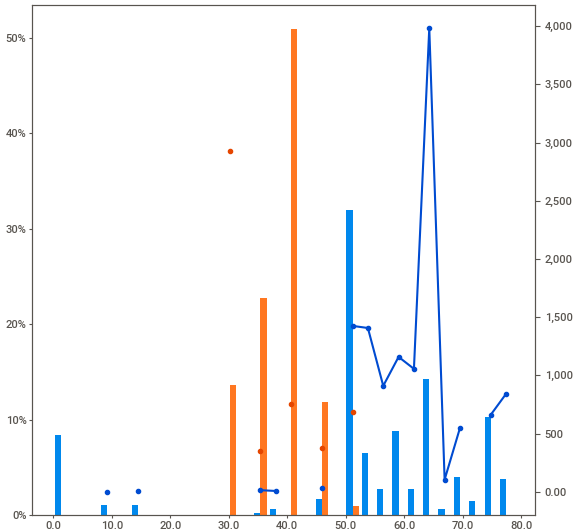
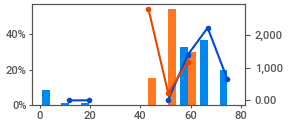
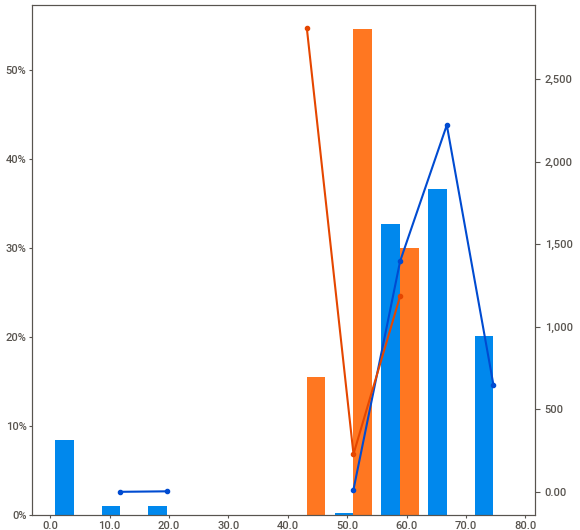
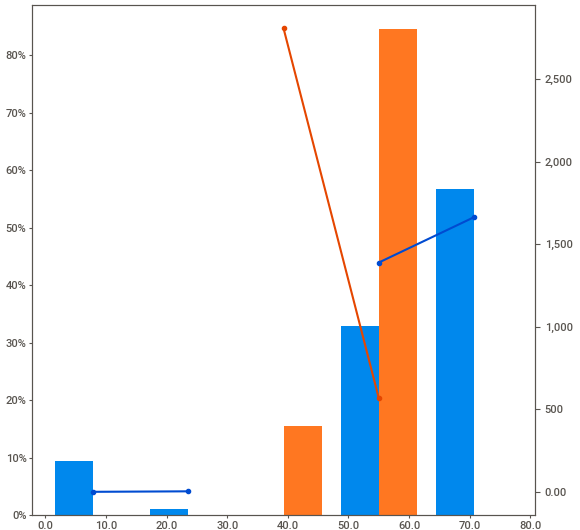
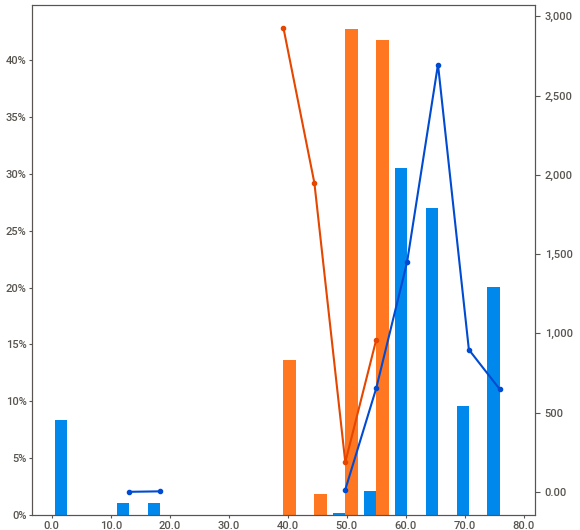
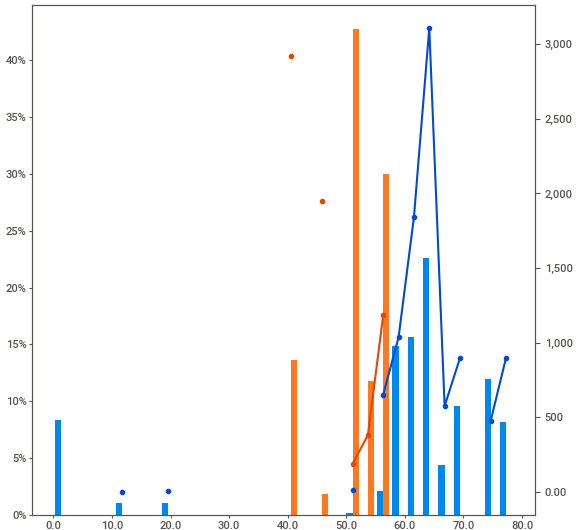
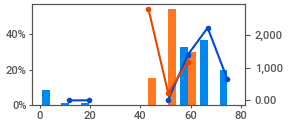
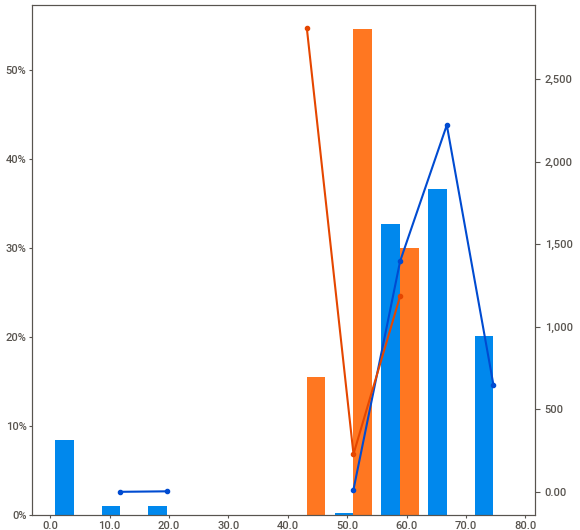
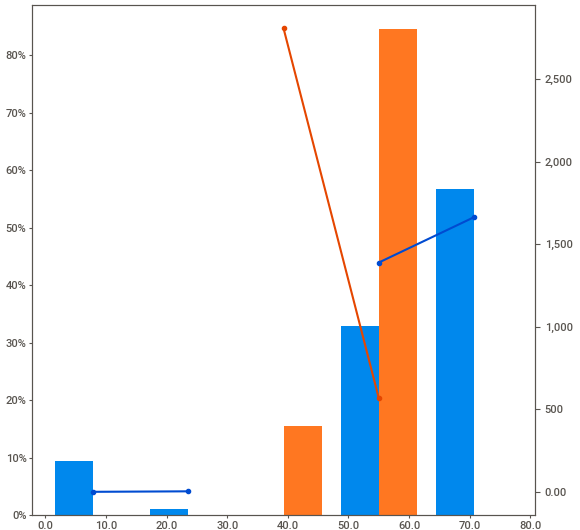
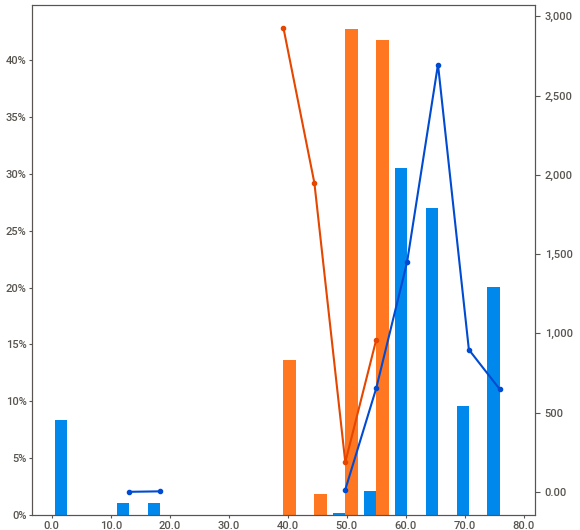
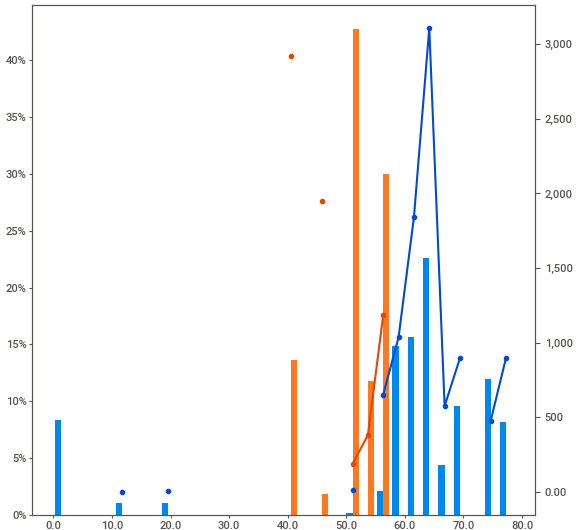
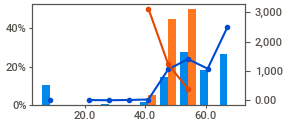
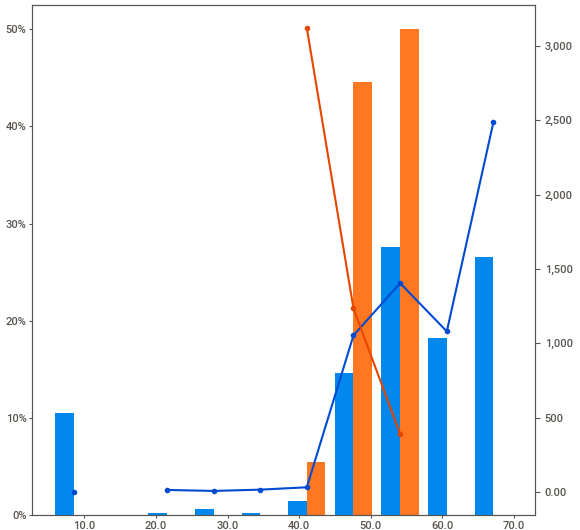
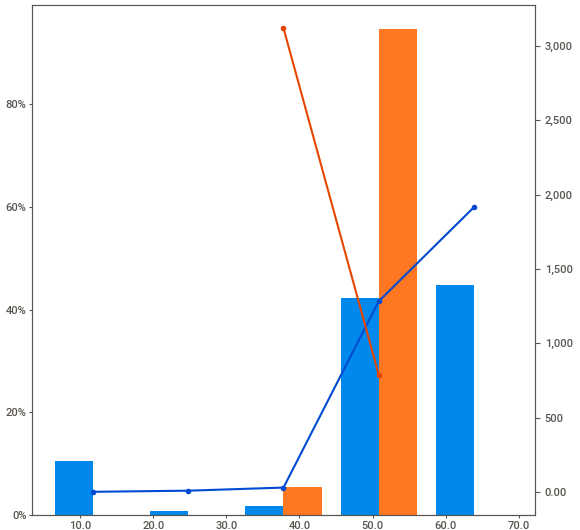
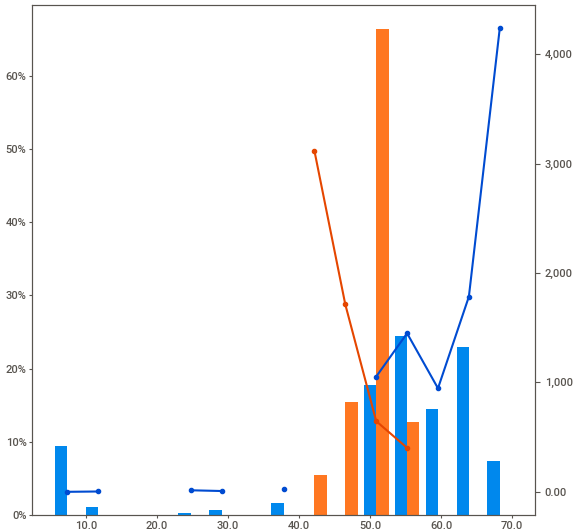
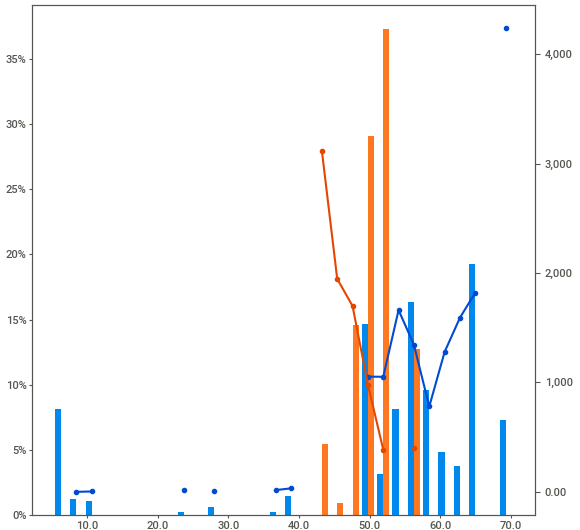
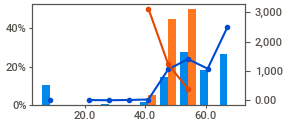
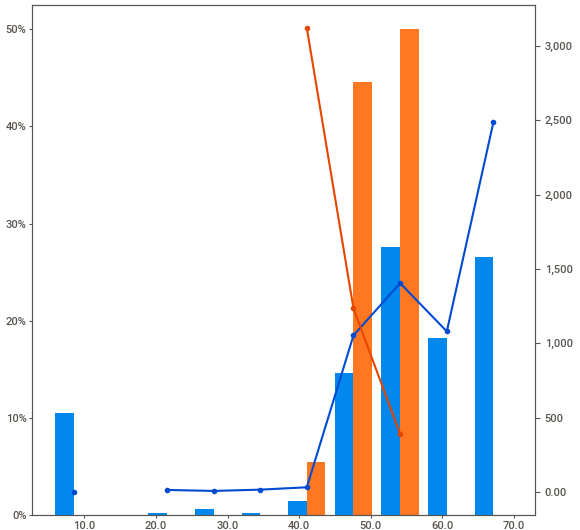
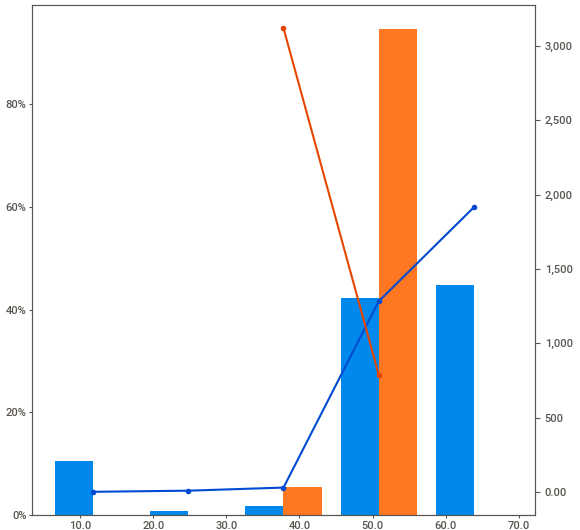
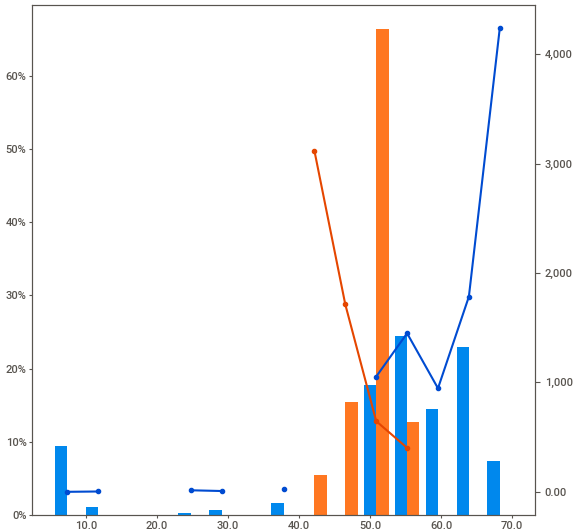
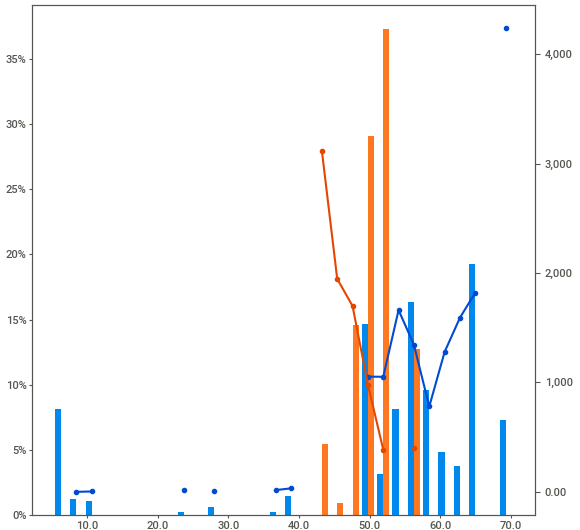
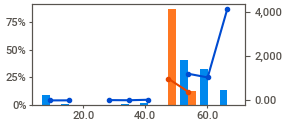
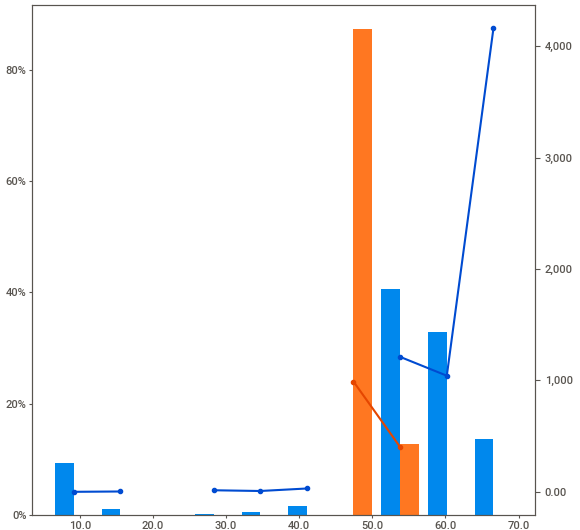
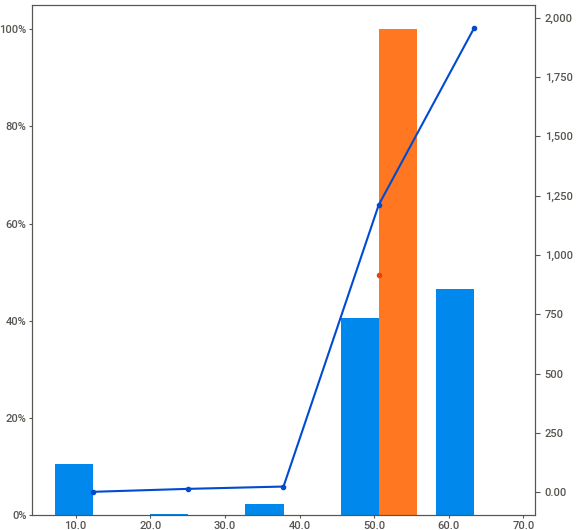
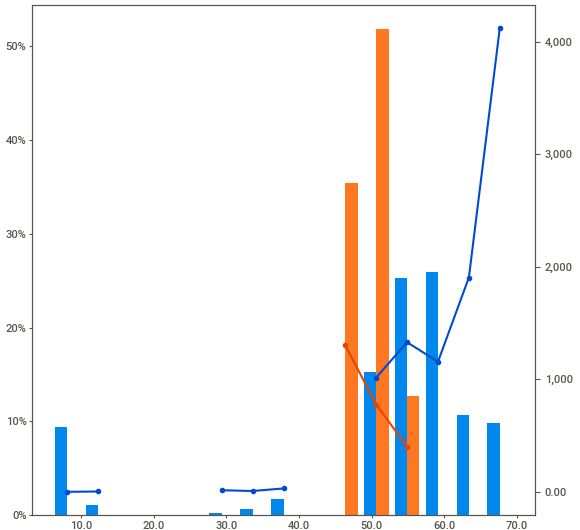
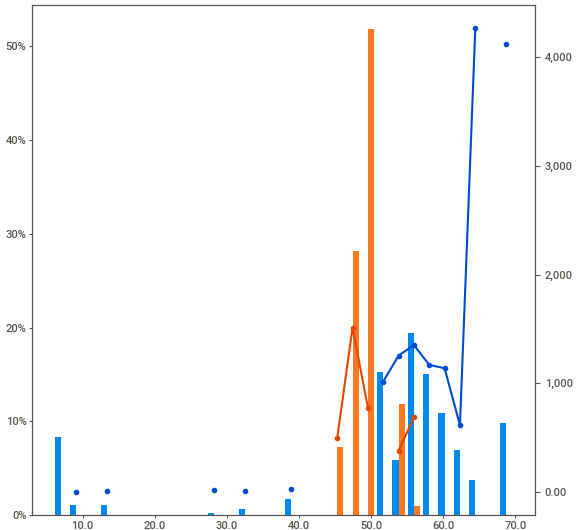
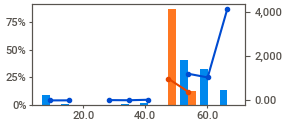
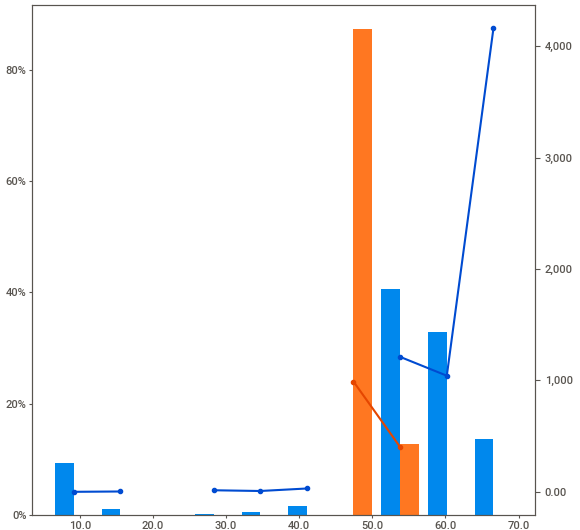
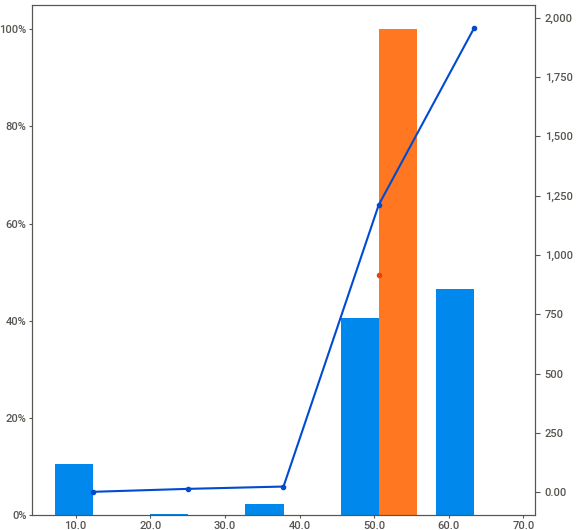
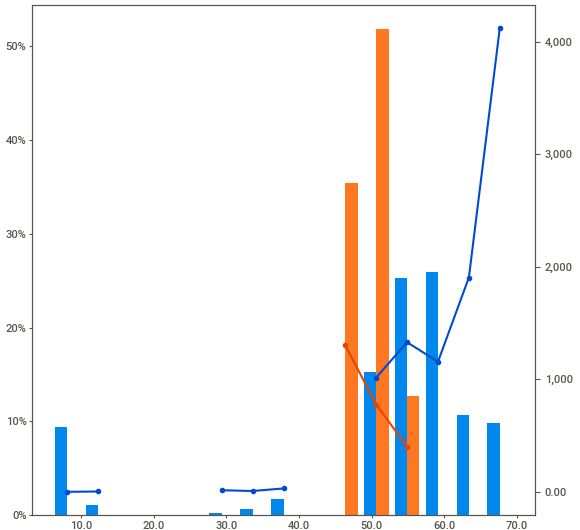
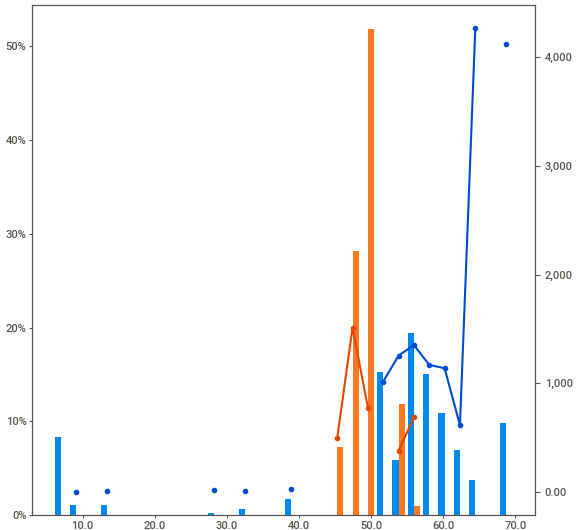
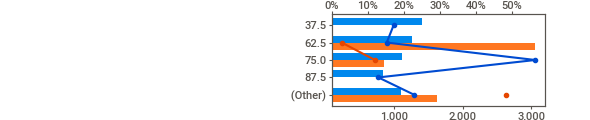
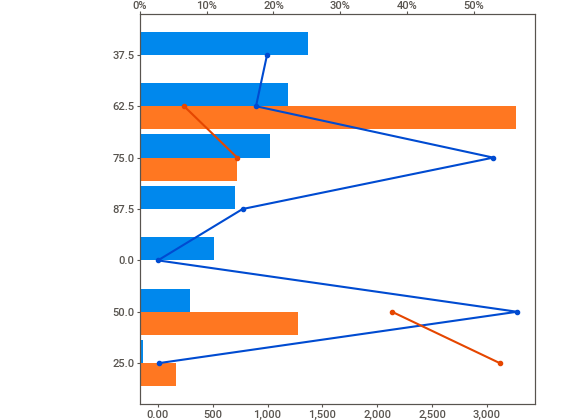
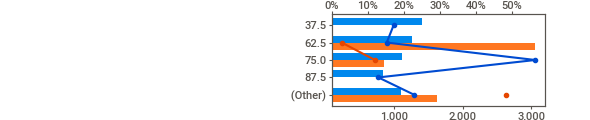
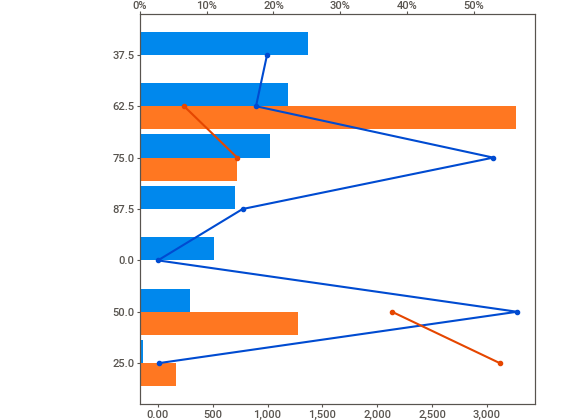
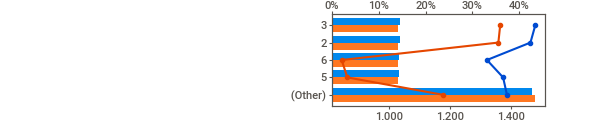
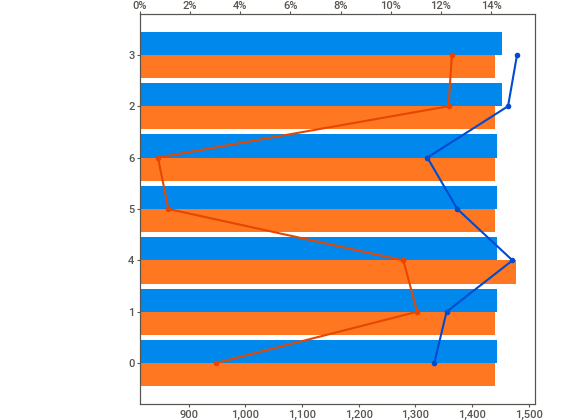
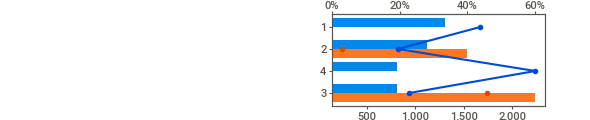
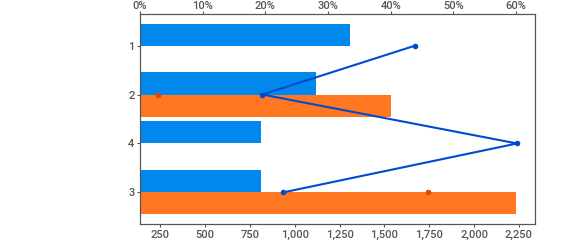
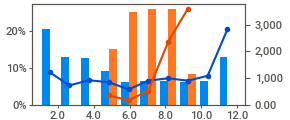
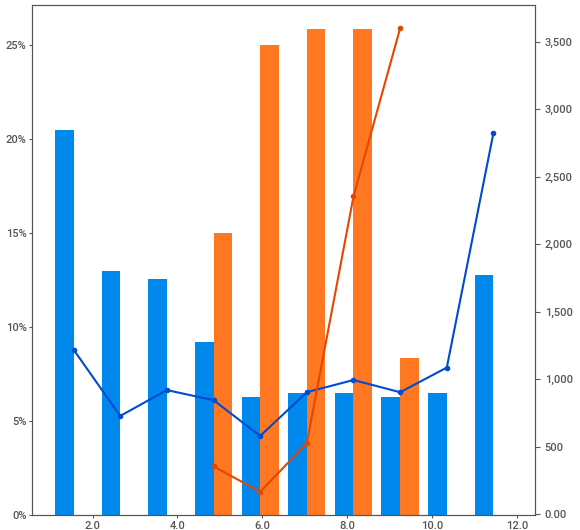
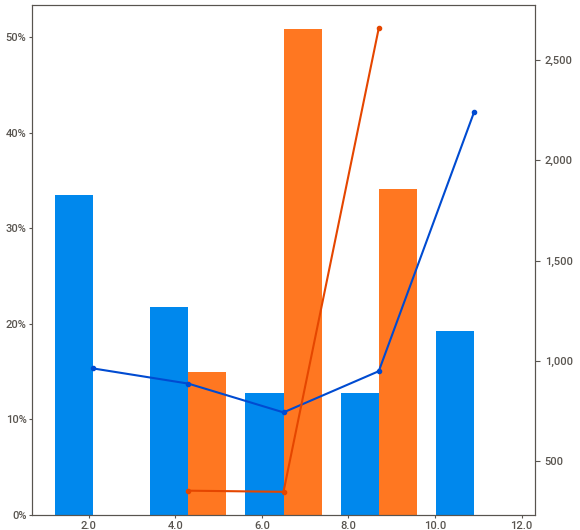
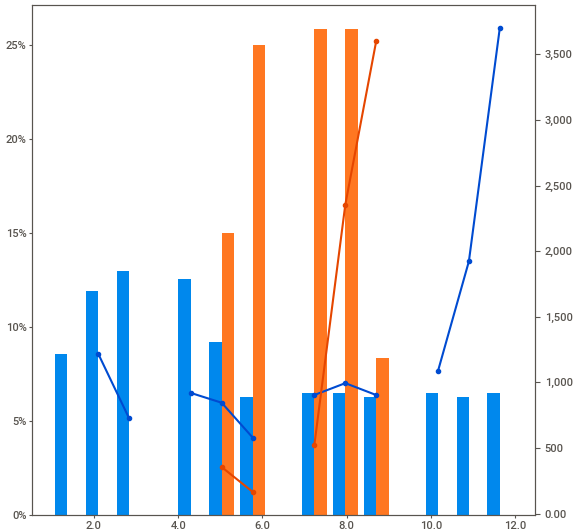
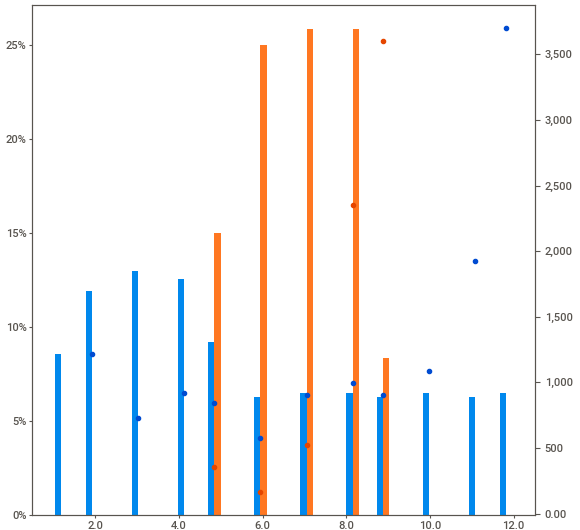
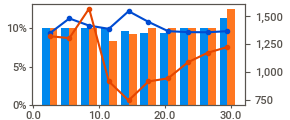
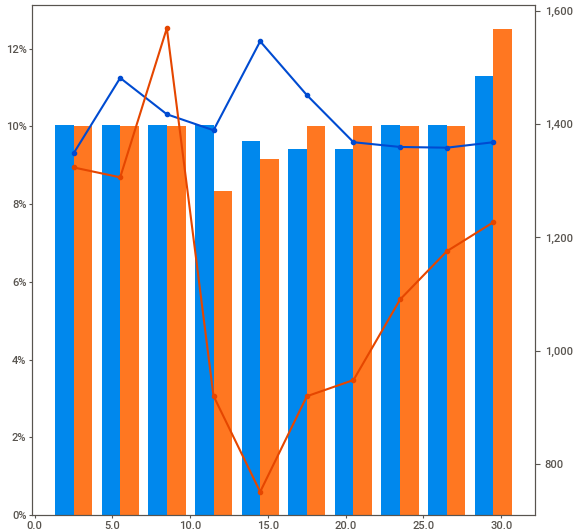
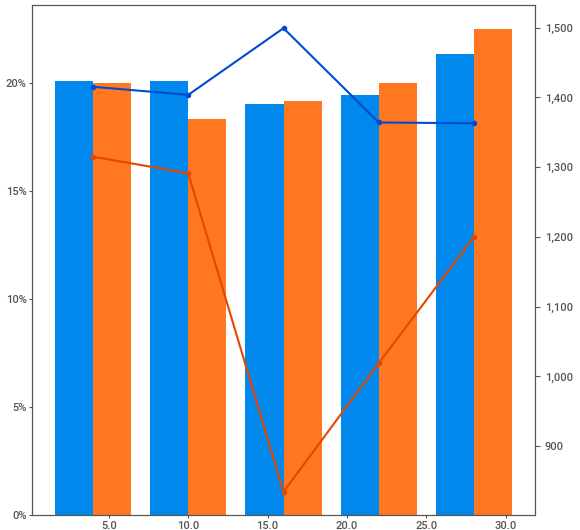
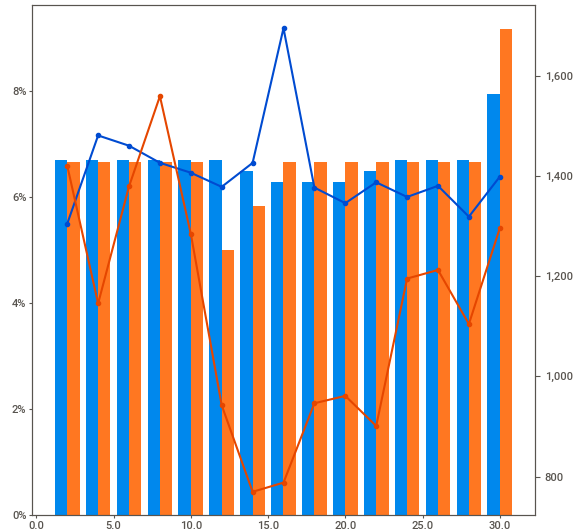
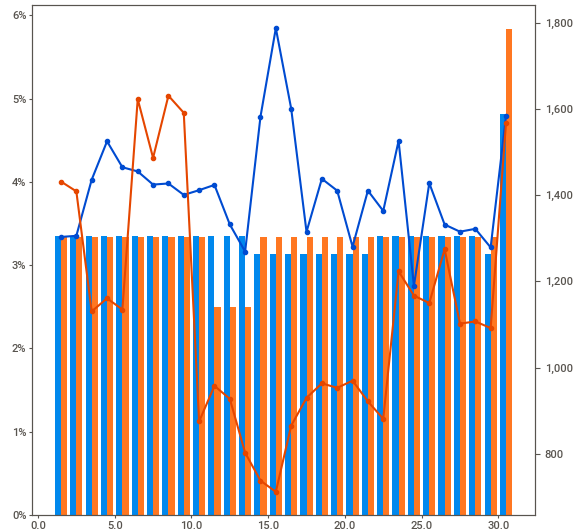
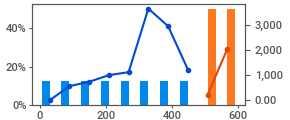
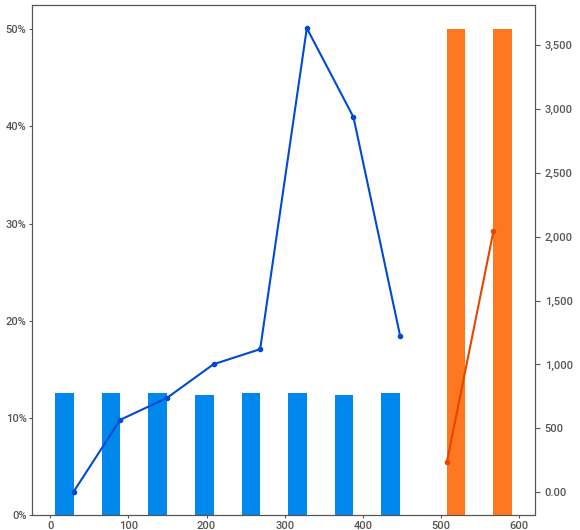
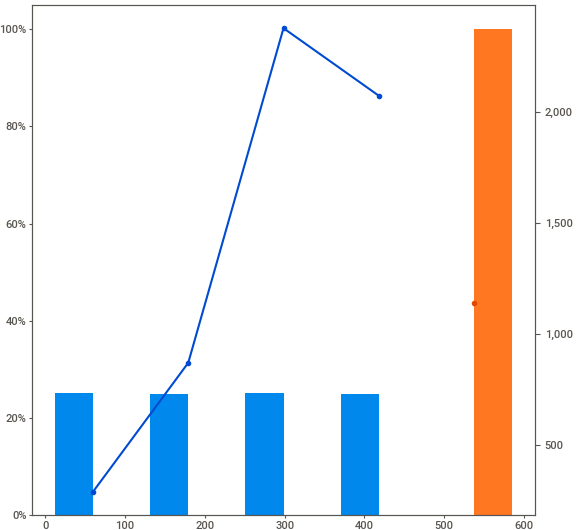
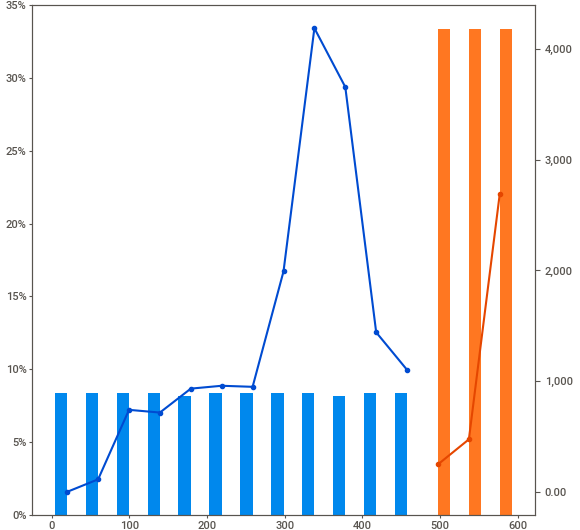
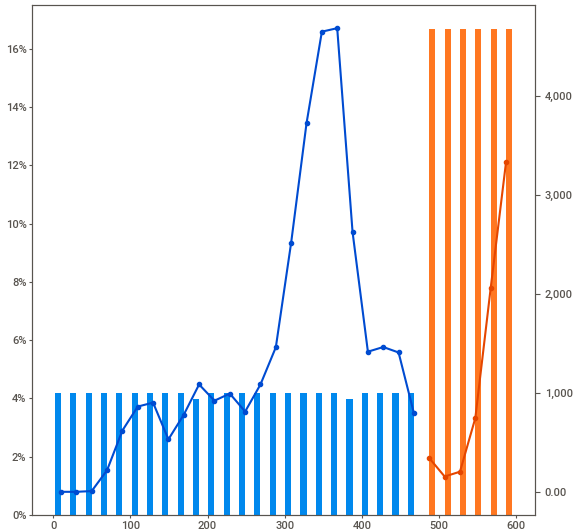
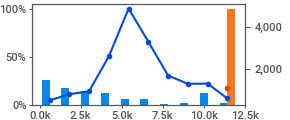
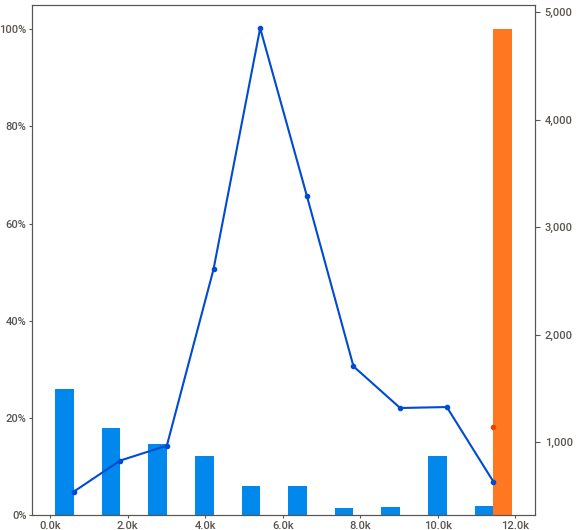
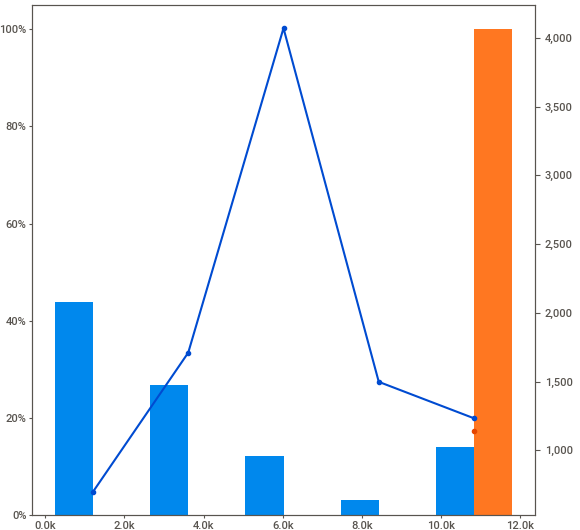
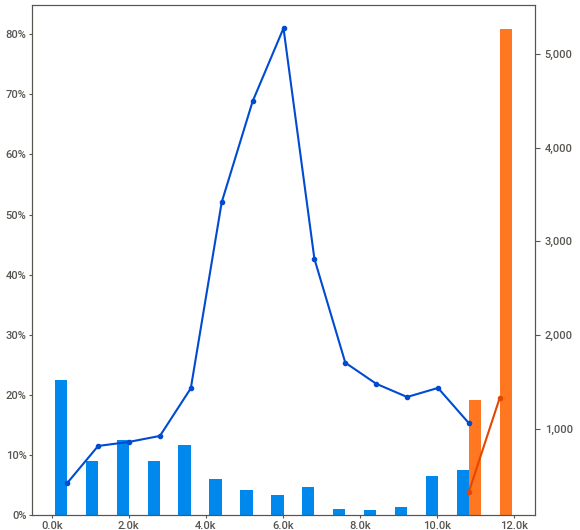
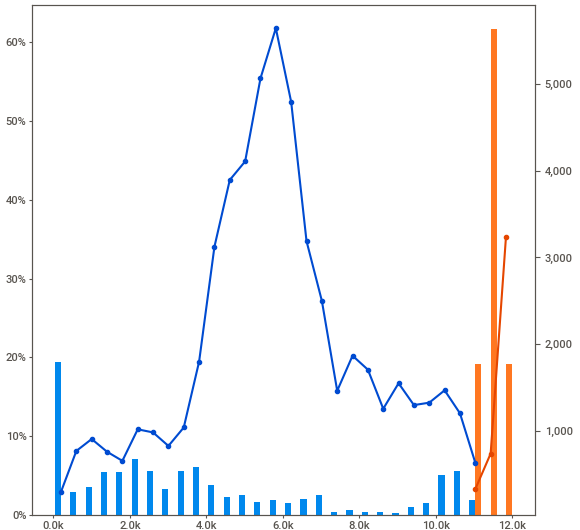
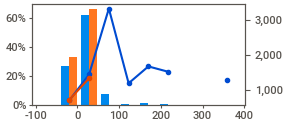
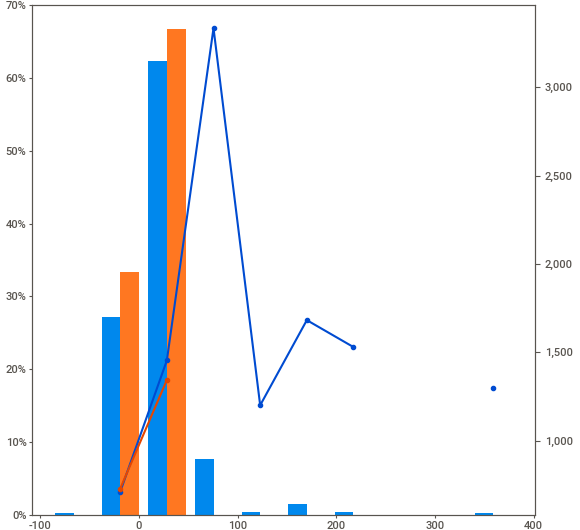
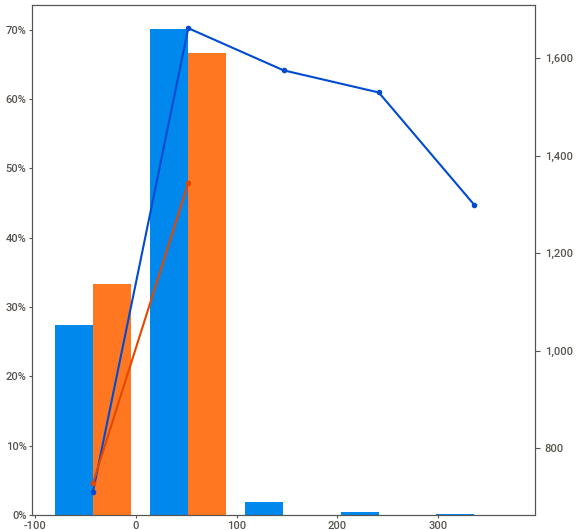
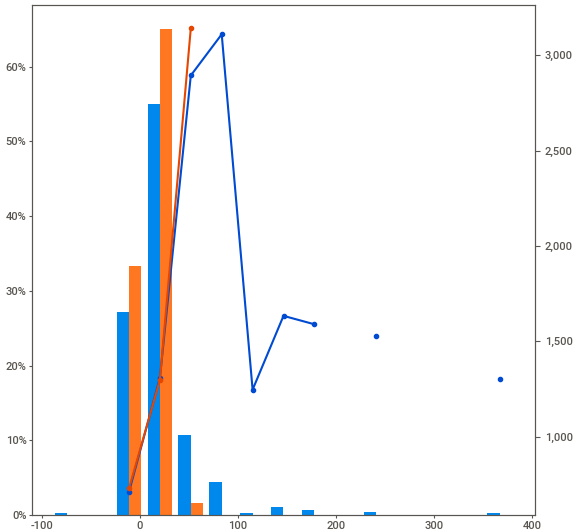
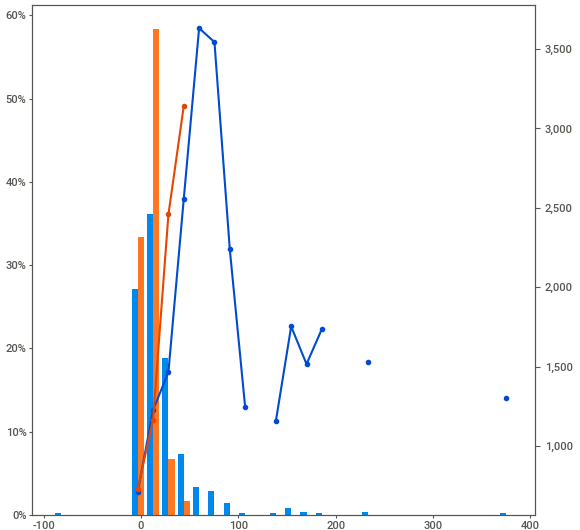
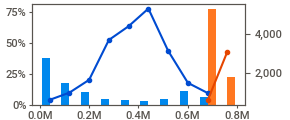
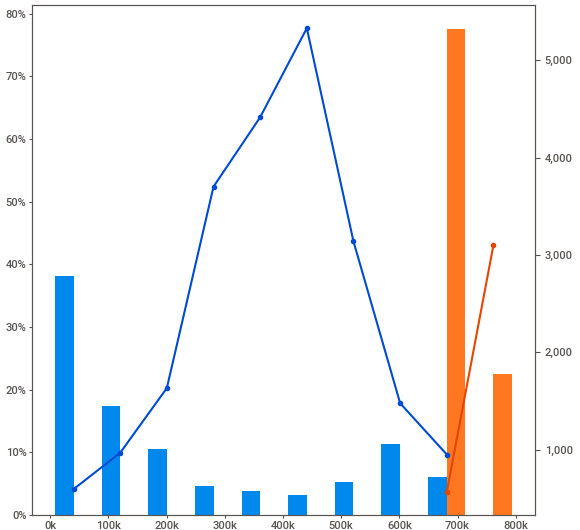
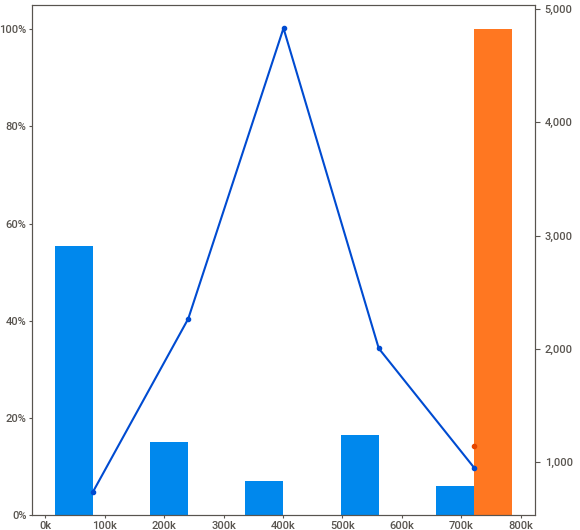
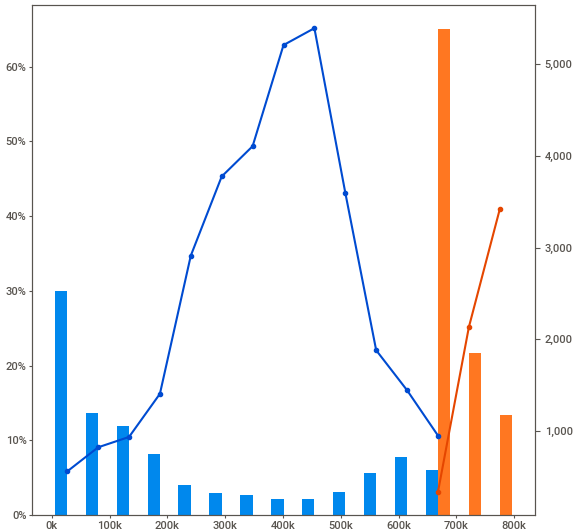
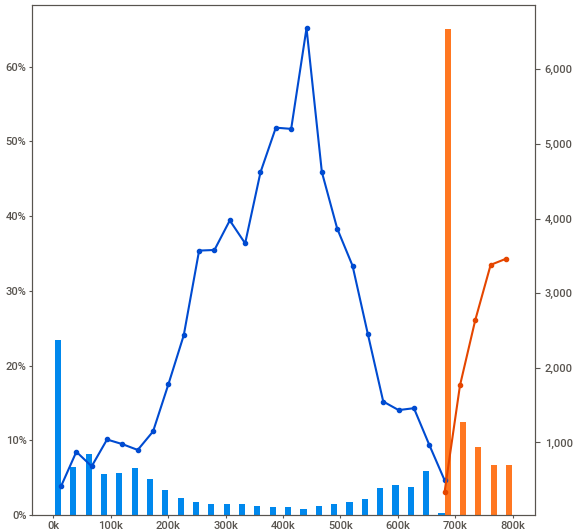
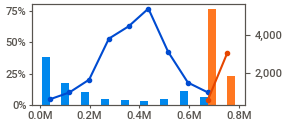
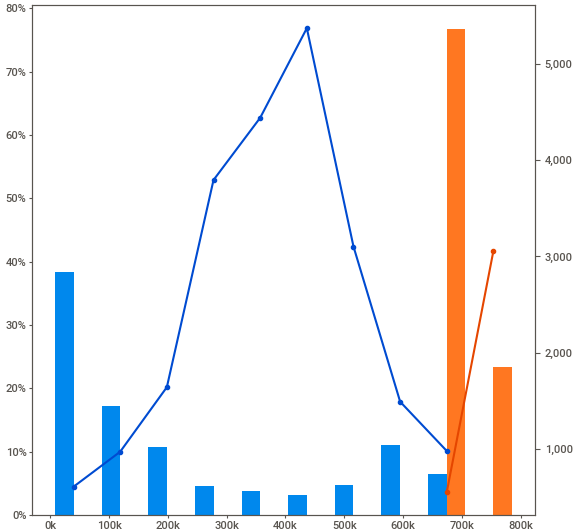
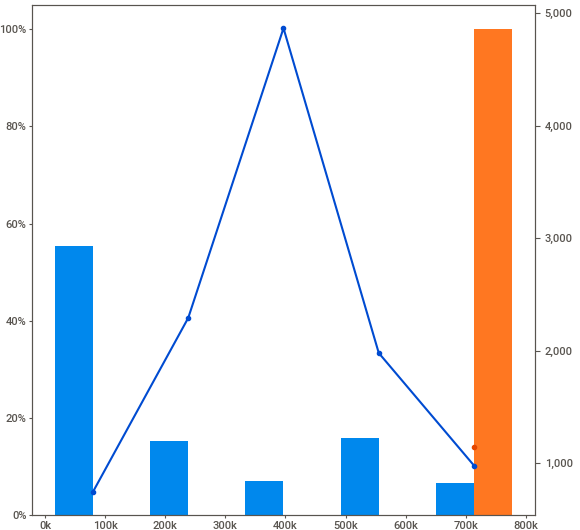
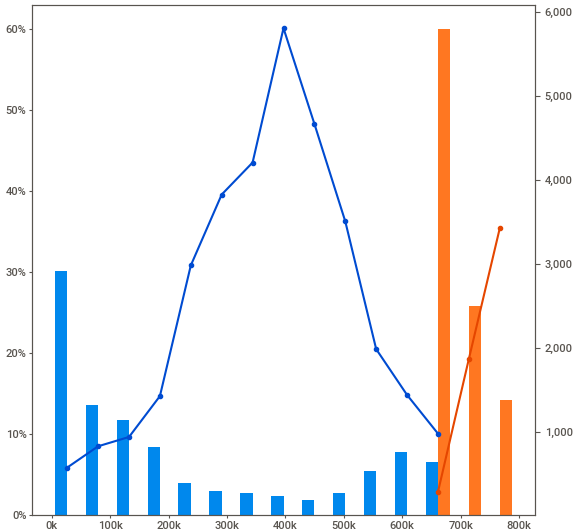
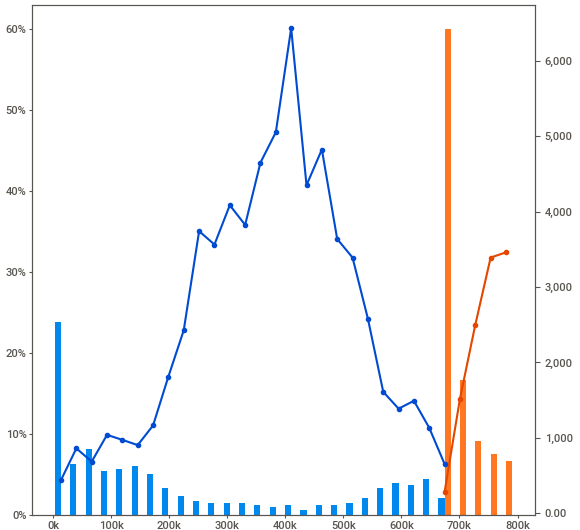
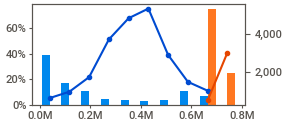
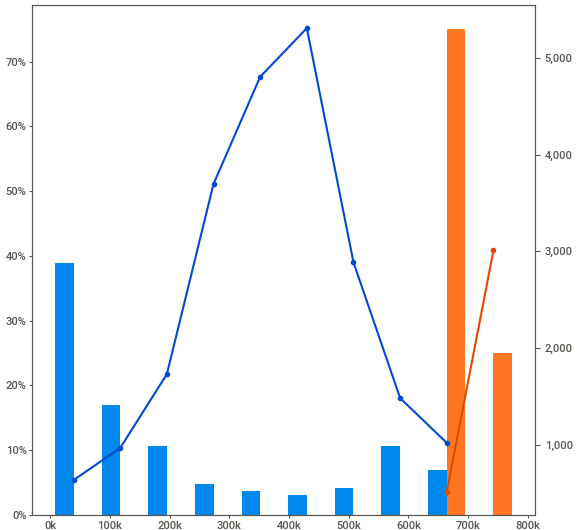
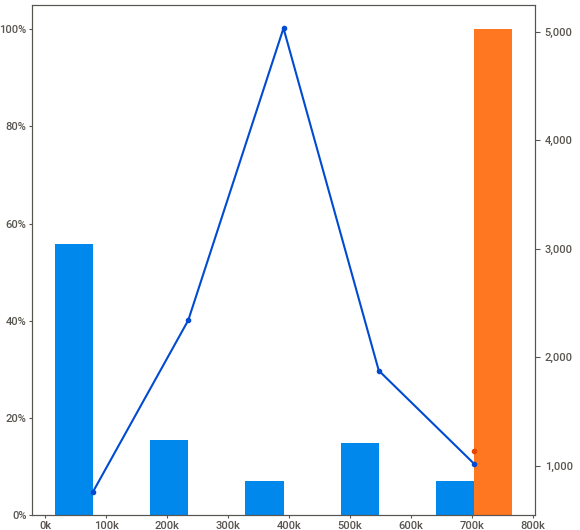
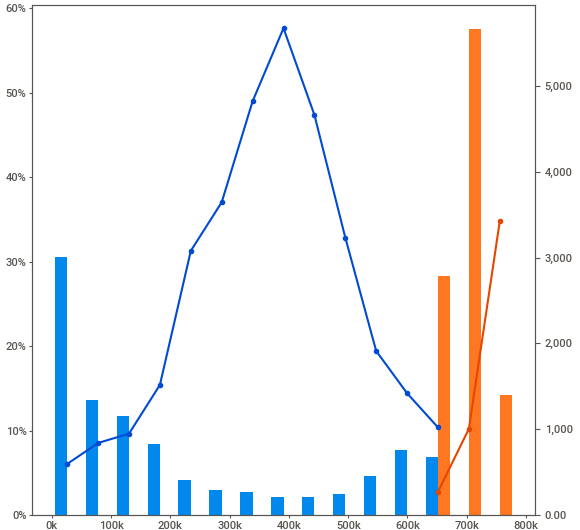
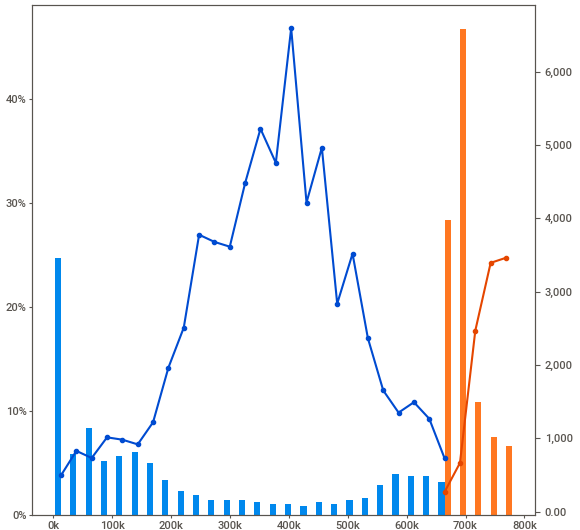
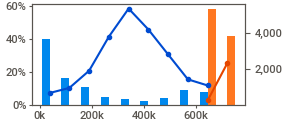
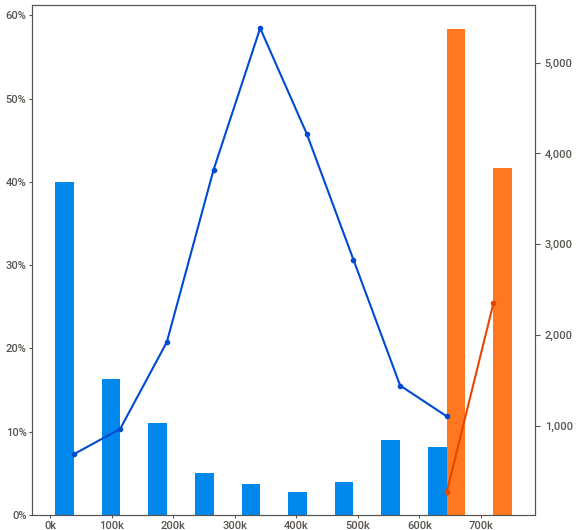
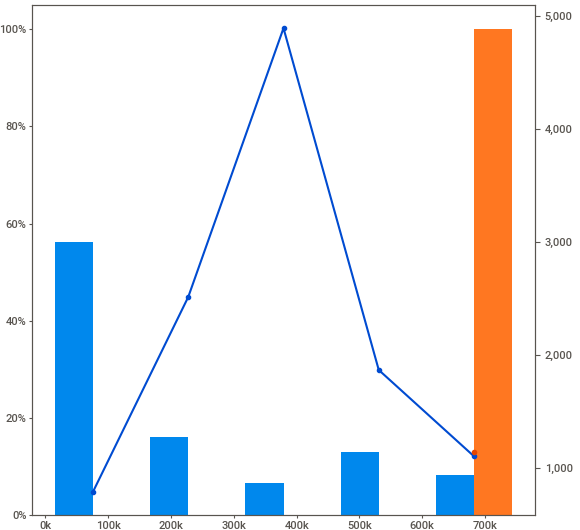
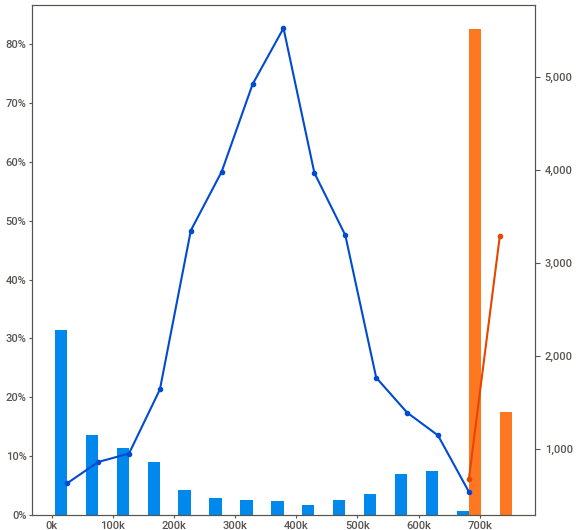
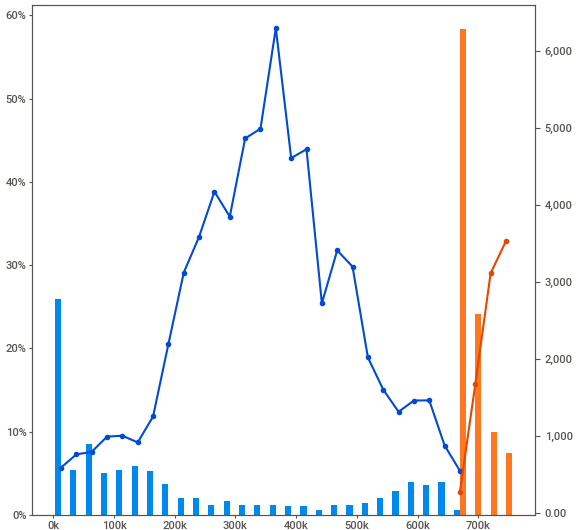
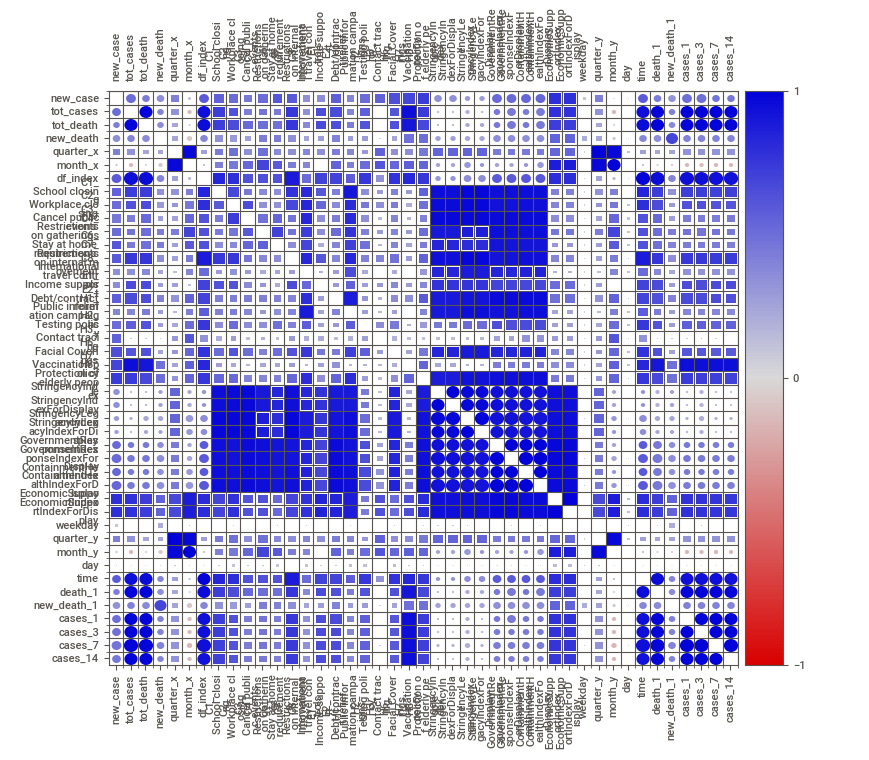
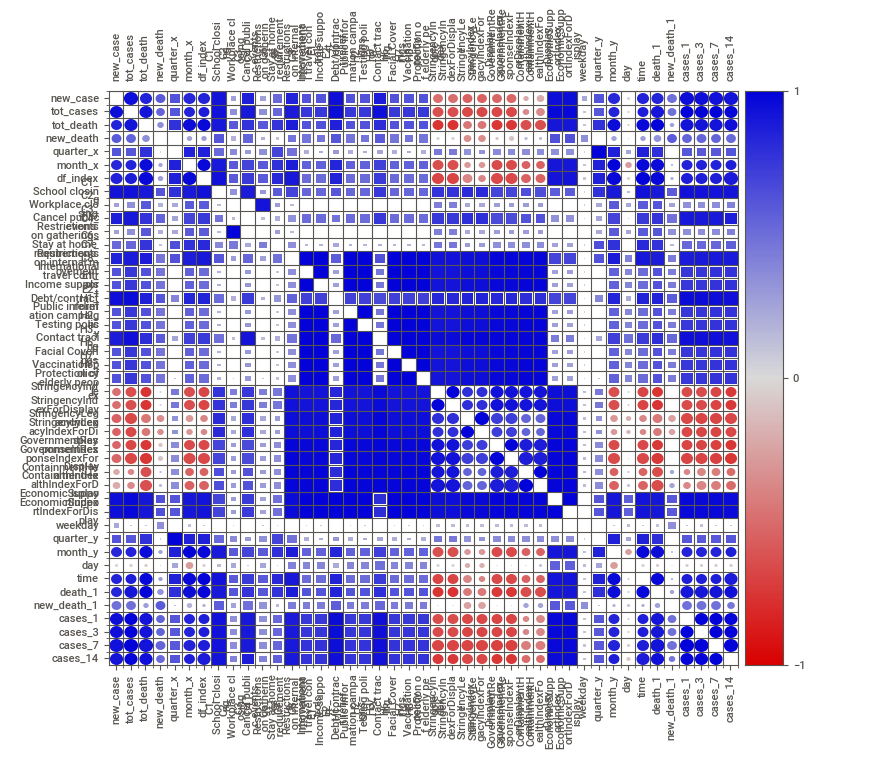

In [ ]:
my_report.show_notebook()